__Import libraries__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [89]:
df=pd.read_csv('well_without_outlier.csv')

In [90]:
df=df.drop('Flow Out %',axis=1)

In [96]:
#Statistical description of the selected features for the target variable ROP
df.describe()

,ROP(1 m),Depth(m),weight on bit (kg),Rotary Speed (rpm),Pump Press (KPa),Temp In(degC),Flow In(liters/min)
count,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000,7293.000000
mean,12.569735,1170.125075,10492.418940,54.855718,8737.605204,47.953857,2710.542394
std,20.194831,654.397245,4130.250795,25.296998,3378.177407,6.626395,511.248043
min,0.000000,25.960000,0.000000,0.000000,137.490000,29.440000,0.000000
25%,3.470000,601.940000,8308.390000,38.120000,4593.170000,42.720000,2347.940000
50%,5.470000,1176.130000,10807.260000,50.380000,9877.500000,47.340000,2650.580000
75%,13.460000,1736.100000,13460.320000,75.950000,11510.100000,52.700000,3120.960000
max,274.750000,2296.940000,21337.870000,178.860000,15171.960000,63.510000,5864.130000


In [91]:
X=df.drop('ROP(1 m)',axis=1)
y=df['ROP(1 m)']
print('the Shape of x is :',X.shape)
print('the Shape of y is :',y.shape)

the Shape of x is : (7293, 6)
the Shape of y is : (7293,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [8]:
#convert the normalized features into numpy array 
scaler=MinMaxScaler().fit(X_train)
scaled_X_train=np.array(scaler.transform(X_train))
scaled_X_test=np.array(scaler.transform(X_test))

In [9]:
#convert the target variable into numpy array 
ny_train=np.array(y_train)
ny_test=np.array(y_test)

In [20]:
#intialize a sequential model to be tuned later
def ANN_model(nl=0,nn=6):
    model = Sequential()
    model.add(Dense(6,input_dim=6,activation="relu"))
    for i in range(nl):
        model.add(Dense(nn, activation='relu'))  
    
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mse',optimizer='adam',metrics=['mse'] )
    return model  
       

In [21]:
ANN_model().summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 42        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6)                 24        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 73
Trainable params: 61
Non-trainable params: 12
_________________________________________________________________


In [22]:
#create a KerasRegressor based on this ANN_model()
Ann_reg=KerasRegressor(build_fn=ANN_model,epochs=200, batch_size=16)

In [23]:
#choosing the number of layers and number of neurons as hyperparameters 
param={'nl':[0,1,2],'nn':[2,3,6,12,24]}
grid_cv = GridSearchCV(Ann_reg, param_grid=param, cv=5,verbose=2,scoring='neg_mean_absolute_error')

In [24]:
grid_cv.fit(scaled_X_train, ny_train,validation_split=0.3 ,callbacks=[EarlyStopping(patience=10)])
#Note that GridSearchCV uses K-fold cross-validation, so it does not use validation_split, These are just used for early stopping


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] nl=0, nn=2 ......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 794us/sample - loss: 527.4588 - mse: 527.4587 - val_loss: 668.2699 - val_mse: 668.2699
Epoch 2/200
2858/2858 [==============================] - 1s 307us/sample - loss: 473.6233 - mse: 473.6232 - val_loss: 611.1885 - val_mse: 611.1885
Epoch 3/200
2858/2858 [==============================] - 1s 269us/sample - loss: 421.2288 - mse: 421.2289 - val_loss: 536.8947 - val_mse: 536.8947
Epoch 4/200
2858/2858 [==============================] - 1s 273us/sample - loss: 370.5135 - mse: 370.5136 - val_loss: 471.4187 - val_mse: 471.4188
Epoch 5/200
2858/2858 [==============================] - 1s 335us/sample - loss: 329.2691 - mse: 329.2690 - val_loss: 420.7240 - val_mse: 420.7240
Epoch 6/200
2858/2858 [==============================] - 1s 301us/sample - loss: 297.0577 - mse: 297.0577 - val_loss: 383.0617 - val_mse: 383.0617
Epoch 7/200
2858/2858 [==============================] - 1s 321us/samp

2858/2858 [==============================] - 1s 289us/sample - loss: 228.9744 - mse: 228.9745 - val_loss: 294.8509 - val_mse: 294.8509
Epoch 57/200
2858/2858 [==============================] - 1s 273us/sample - loss: 225.7079 - mse: 225.7080 - val_loss: 293.9899 - val_mse: 293.9899
[CV] ....................................... nl=0, nn=2, total=  46.2s
[CV] nl=0, nn=2 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.1s remaining:    0.0s


Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 605us/sample - loss: 477.6645 - mse: 477.6646 - val_loss: 667.2606 - val_mse: 667.2606
Epoch 2/200
2858/2858 [==============================] - 1s 242us/sample - loss: 440.5154 - mse: 440.5155 - val_loss: 618.6818 - val_mse: 618.6818
Epoch 3/200
2858/2858 [==============================] - 1s 289us/sample - loss: 396.5541 - mse: 396.5541 - val_loss: 555.6858 - val_mse: 555.6857
Epoch 4/200
2858/2858 [==============================] - 1s 266us/sample - loss: 349.2001 - mse: 349.2001 - val_loss: 494.7915 - val_mse: 494.7914
Epoch 5/200
2858/2858 [==============================] - 1s 256us/sample - loss: 306.7534 - mse: 306.7534 - val_loss: 445.9353 - val_mse: 445.9354
Epoch 6/200
2858/2858 [==============================] - 1s 248us/sample - loss: 274.5671 - mse: 274.5671 - val_loss: 406.2696 - val_mse: 406.2696
Epoch 7/200
2858/2858 [==============================] - 1s 252us/samp

2858/2858 [==============================] - 1s 245us/sample - loss: 214.6769 - mse: 214.6770 - val_loss: 227.6859 - val_mse: 227.6858
Epoch 13/200
2858/2858 [==============================] - 1s 255us/sample - loss: 207.7301 - mse: 207.7301 - val_loss: 220.8369 - val_mse: 220.8369
Epoch 14/200
2858/2858 [==============================] - 1s 224us/sample - loss: 206.2212 - mse: 206.2212 - val_loss: 219.8274 - val_mse: 219.8275
Epoch 15/200
2858/2858 [==============================] - 1s 273us/sample - loss: 201.9633 - mse: 201.9633 - val_loss: 213.2714 - val_mse: 213.2714
Epoch 16/200
2858/2858 [==============================] - 1s 260us/sample - loss: 202.9699 - mse: 202.9698 - val_loss: 212.3204 - val_mse: 212.3204
Epoch 17/200
2858/2858 [==============================] - 1s 305us/sample - loss: 203.8945 - mse: 203.8945 - val_loss: 210.9007 - val_mse: 210.9007
Epoch 18/200
2858/2858 [==============================] - 1s 278us/sample - loss: 197.5148 - mse: 197.5147 - val_loss: 208.92

2858/2858 [==============================] - 1s 289us/sample - loss: 163.5824 - mse: 163.5824 - val_loss: 166.1811 - val_mse: 166.1811
Epoch 68/200
2858/2858 [==============================] - 1s 275us/sample - loss: 163.5921 - mse: 163.5920 - val_loss: 165.5434 - val_mse: 165.5434
Epoch 69/200
2858/2858 [==============================] - 1s 276us/sample - loss: 164.7508 - mse: 164.7508 - val_loss: 162.4562 - val_mse: 162.4562
Epoch 70/200
2858/2858 [==============================] - 1s 289us/sample - loss: 166.2591 - mse: 166.2591 - val_loss: 161.7975 - val_mse: 161.7975
Epoch 71/200
2858/2858 [==============================] - 1s 274us/sample - loss: 160.1877 - mse: 160.1877 - val_loss: 160.8960 - val_mse: 160.8960
Epoch 72/200
2858/2858 [==============================] - 1s 271us/sample - loss: 163.1534 - mse: 163.1534 - val_loss: 162.4457 - val_mse: 162.4457
Epoch 73/200
2858/2858 [==============================] - 1s 283us/sample - loss: 169.7842 - mse: 169.7842 - val_loss: 163.19

2858/2858 [==============================] - 1s 247us/sample - loss: 190.8737 - mse: 190.8737 - val_loss: 188.7482 - val_mse: 188.7481
Epoch 11/200
2858/2858 [==============================] - 1s 242us/sample - loss: 186.8698 - mse: 186.8697 - val_loss: 180.6381 - val_mse: 180.6381
Epoch 12/200
2858/2858 [==============================] - 1s 220us/sample - loss: 186.8247 - mse: 186.8247 - val_loss: 174.7014 - val_mse: 174.7014
Epoch 13/200
2858/2858 [==============================] - 1s 236us/sample - loss: 182.6189 - mse: 182.6189 - val_loss: 170.7165 - val_mse: 170.7165
Epoch 14/200
2858/2858 [==============================] - 1s 242us/sample - loss: 180.3954 - mse: 180.3954 - val_loss: 167.2090 - val_mse: 167.2090
Epoch 15/200
2858/2858 [==============================] - 1s 221us/sample - loss: 180.7099 - mse: 180.7099 - val_loss: 169.5784 - val_mse: 169.5784
Epoch 16/200
2858/2858 [==============================] - 1s 259us/sample - loss: 181.3658 - mse: 181.3658 - val_loss: 165.07

2858/2858 [==============================] - 1s 252us/sample - loss: 153.3655 - mse: 153.3655 - val_loss: 138.8527 - val_mse: 138.8526
Epoch 66/200
2858/2858 [==============================] - 1s 252us/sample - loss: 164.6241 - mse: 164.6240 - val_loss: 138.8572 - val_mse: 138.8572
Epoch 67/200
2858/2858 [==============================] - 1s 224us/sample - loss: 160.3590 - mse: 160.3590 - val_loss: 139.3288 - val_mse: 139.3288
Epoch 68/200
2858/2858 [==============================] - 1s 238us/sample - loss: 160.1237 - mse: 160.1237 - val_loss: 138.8399 - val_mse: 138.8399
Epoch 69/200
2858/2858 [==============================] - ETA: 0s - loss: 160.2617 - mse: 160.261 - 1s 216us/sample - loss: 157.6929 - mse: 157.6929 - val_loss: 137.9297 - val_mse: 137.9296
Epoch 70/200
2858/2858 [==============================] - 1s 196us/sample - loss: 159.0626 - mse: 159.0626 - val_loss: 137.0059 - val_mse: 137.0059
Epoch 71/200
2858/2858 [==============================] - 1s 227us/sample - loss: 1

2858/2858 [==============================] - 1s 280us/sample - loss: 156.3601 - mse: 156.3601 - val_loss: 131.1776 - val_mse: 131.1776
[CV] ....................................... nl=0, nn=2, total= 1.5min
[CV] nl=0, nn=2 ......................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 563us/sample - loss: 455.7976 - mse: 455.7976 - val_loss: 620.1799 - val_mse: 620.1798
Epoch 2/200
2858/2858 [==============================] - 1s 234us/sample - loss: 405.5016 - mse: 405.5015 - val_loss: 568.4156 - val_mse: 568.4156
Epoch 3/200
2858/2858 [==============================] - 1s 287us/sample - loss: 336.5397 - mse: 336.5397 - val_loss: 459.4224 - val_mse: 459.4224
Epoch 4/200
2858/2858 [==============================] - 1s 346us/sample - loss: 288.0857 - mse: 288.0857 - val_loss: 384.2993 - val_mse: 384.2993
Epoch 5/200
2858/2858 [==============================] - 1s 257us/sample - loss: 257.83

2858/2858 [==============================] - 1s 214us/sample - loss: 168.9563 - mse: 168.9563 - val_loss: 225.4433 - val_mse: 225.4433
Epoch 55/200
2858/2858 [==============================] - 1s 235us/sample - loss: 166.1981 - mse: 166.1981 - val_loss: 227.6121 - val_mse: 227.6121
Epoch 56/200
2858/2858 [==============================] - 1s 237us/sample - loss: 166.4689 - mse: 166.4688 - val_loss: 220.8066 - val_mse: 220.8066
Epoch 57/200
2858/2858 [==============================] - 1s 224us/sample - loss: 166.2674 - mse: 166.2674 - val_loss: 219.9646 - val_mse: 219.9646
Epoch 58/200
2858/2858 [==============================] - 1s 218us/sample - loss: 163.8911 - mse: 163.8911 - val_loss: 220.3315 - val_mse: 220.3315
Epoch 59/200
2858/2858 [==============================] - 1s 237us/sample - loss: 161.8710 - mse: 161.8710 - val_loss: 218.1211 - val_mse: 218.1211
Epoch 60/200
2858/2858 [==============================] - 1s 228us/sample - loss: 166.8430 - mse: 166.8430 - val_loss: 219.57

Epoch 109/200
2858/2858 [==============================] - 1s 265us/sample - loss: 151.4017 - mse: 151.4016 - val_loss: 196.4925 - val_mse: 196.4924
Epoch 110/200
2858/2858 [==============================] - 1s 275us/sample - loss: 151.5097 - mse: 151.5097 - val_loss: 197.5772 - val_mse: 197.5772
Epoch 111/200
2858/2858 [==============================] - 1s 270us/sample - loss: 148.1557 - mse: 148.1557 - val_loss: 196.4600 - val_mse: 196.4600
Epoch 112/200
2858/2858 [==============================] - 1s 266us/sample - loss: 153.2659 - mse: 153.2659 - val_loss: 199.0342 - val_mse: 199.0342
Epoch 113/200
2858/2858 [==============================] - 1s 265us/sample - loss: 143.2798 - mse: 143.2798 - val_loss: 195.0959 - val_mse: 195.0959
Epoch 114/200
2858/2858 [==============================] - 1s 270us/sample - loss: 150.3924 - mse: 150.3925 - val_loss: 193.7363 - val_mse: 193.7364
Epoch 115/200
2858/2858 [==============================] - 1s 264us/sample - loss: 146.1326 - mse: 146.132

Epoch 20/200
2858/2858 [==============================] - 1s 238us/sample - loss: 205.7954 - mse: 205.7954 - val_loss: 241.4233 - val_mse: 241.4233
Epoch 21/200
2858/2858 [==============================] - 1s 260us/sample - loss: 199.2915 - mse: 199.2915 - val_loss: 242.7980 - val_mse: 242.7979
Epoch 22/200
2858/2858 [==============================] - 1s 273us/sample - loss: 196.7583 - mse: 196.7582 - val_loss: 235.1845 - val_mse: 235.1845
Epoch 23/200
2858/2858 [==============================] - 1s 265us/sample - loss: 203.1303 - mse: 203.1303 - val_loss: 236.0841 - val_mse: 236.0841
Epoch 24/200
2858/2858 [==============================] - 1s 273us/sample - loss: 198.4608 - mse: 198.4608 - val_loss: 236.3112 - val_mse: 236.3112
Epoch 25/200
2858/2858 [==============================] - 1s 262us/sample - loss: 198.2469 - mse: 198.2468 - val_loss: 233.5791 - val_mse: 233.5791
Epoch 26/200
2858/2858 [==============================] - 1s 242us/sample - loss: 192.5848 - mse: 192.5848 - val

2858/2858 [==============================] - 1s 252us/sample - loss: 170.2257 - mse: 170.2257 - val_loss: 193.3362 - val_mse: 193.3362
Epoch 76/200
2858/2858 [==============================] - 1s 276us/sample - loss: 164.2555 - mse: 164.2556 - val_loss: 188.9633 - val_mse: 188.9633
Epoch 77/200
2858/2858 [==============================] - 1s 256us/sample - loss: 171.2272 - mse: 171.2272 - val_loss: 187.4320 - val_mse: 187.4319
Epoch 78/200
2858/2858 [==============================] - 1s 266us/sample - loss: 163.3228 - mse: 163.3228 - val_loss: 189.2987 - val_mse: 189.2987
Epoch 79/200
2858/2858 [==============================] - 1s 302us/sample - loss: 168.3168 - mse: 168.3168 - val_loss: 187.0987 - val_mse: 187.0987
Epoch 80/200
2858/2858 [==============================] - 1s 290us/sample - loss: 164.9217 - mse: 164.9217 - val_loss: 187.4140 - val_mse: 187.4140
Epoch 81/200
2858/2858 [==============================] - 1s 263us/sample - loss: 169.2416 - mse: 169.2416 - val_loss: 192.59

2858/2858 [==============================] - 1s 253us/sample - loss: 141.6483 - mse: 141.6483 - val_loss: 191.0369 - val_mse: 191.0369
Epoch 46/200
2858/2858 [==============================] - 1s 249us/sample - loss: 143.9595 - mse: 143.9595 - val_loss: 192.5021 - val_mse: 192.5021
Epoch 47/200
2858/2858 [==============================] - 1s 249us/sample - loss: 140.3571 - mse: 140.3571 - val_loss: 195.0513 - val_mse: 195.0513
Epoch 48/200
2858/2858 [==============================] - 1s 241us/sample - loss: 146.4543 - mse: 146.4543 - val_loss: 191.9442 - val_mse: 191.9442
Epoch 49/200
2858/2858 [==============================] - 1s 251us/sample - loss: 142.1136 - mse: 142.1136 - val_loss: 194.7857 - val_mse: 194.7857
Epoch 50/200
2858/2858 [==============================] - 1s 248us/sample - loss: 137.6082 - mse: 137.6082 - val_loss: 189.2490 - val_mse: 189.2490
Epoch 51/200
2858/2858 [==============================] - 1s 236us/sample - loss: 142.8435 - mse: 142.8435 - val_loss: 191.85

2858/2858 [==============================] - 1s 255us/sample - loss: 159.9496 - mse: 159.9496 - val_loss: 169.8014 - val_mse: 169.8014
Epoch 40/200
2858/2858 [==============================] - 1s 255us/sample - loss: 161.0814 - mse: 161.0814 - val_loss: 169.0480 - val_mse: 169.0480
Epoch 41/200
2858/2858 [==============================] - 1s 242us/sample - loss: 166.5124 - mse: 166.5123 - val_loss: 168.0973 - val_mse: 168.0973
Epoch 42/200
2858/2858 [==============================] - 1s 252us/sample - loss: 171.0294 - mse: 171.0293 - val_loss: 167.6134 - val_mse: 167.6134
Epoch 43/200
2858/2858 [==============================] - 1s 248us/sample - loss: 163.6107 - mse: 163.6107 - val_loss: 166.4197 - val_mse: 166.4197
Epoch 44/200
2858/2858 [==============================] - 1s 254us/sample - loss: 156.3332 - mse: 156.3332 - val_loss: 165.9987 - val_mse: 165.9987
Epoch 45/200
2858/2858 [==============================] - ETA: 0s - loss: 162.1894 - mse: 162.189 - 1s 255us/sample - loss: 1

Epoch 94/200
2858/2858 [==============================] - 1s 288us/sample - loss: 161.0895 - mse: 161.0896 - val_loss: 141.9758 - val_mse: 141.9758
Epoch 95/200
2858/2858 [==============================] - 1s 265us/sample - loss: 146.9963 - mse: 146.9963 - val_loss: 138.6382 - val_mse: 138.6383
Epoch 96/200
2858/2858 [==============================] - 1s 287us/sample - loss: 148.3512 - mse: 148.3513 - val_loss: 140.7887 - val_mse: 140.7887
Epoch 97/200
2858/2858 [==============================] - 1s 298us/sample - loss: 151.2402 - mse: 151.2402 - val_loss: 139.3338 - val_mse: 139.3337
Epoch 98/200
2858/2858 [==============================] - 1s 294us/sample - loss: 146.3871 - mse: 146.3871 - val_loss: 140.3326 - val_mse: 140.3326
Epoch 99/200
2858/2858 [==============================] - 1s 280us/sample - loss: 149.9377 - mse: 149.9378 - val_loss: 137.1541 - val_mse: 137.1541
Epoch 100/200
2858/2858 [==============================] - 1s 280us/sample - loss: 153.2574 - mse: 153.2574 - va

2858/2858 [==============================] - 1s 266us/sample - loss: 137.1211 - mse: 137.1212 - val_loss: 128.4028 - val_mse: 128.4028
Epoch 150/200
2858/2858 [==============================] - 1s 268us/sample - loss: 142.3632 - mse: 142.3632 - val_loss: 125.0724 - val_mse: 125.0724
Epoch 151/200
2858/2858 [==============================] - 1s 270us/sample - loss: 144.3610 - mse: 144.3610 - val_loss: 124.8853 - val_mse: 124.8853
Epoch 152/200
2858/2858 [==============================] - 1s 281us/sample - loss: 137.8595 - mse: 137.8595 - val_loss: 124.3770 - val_mse: 124.3769
Epoch 153/200
2858/2858 [==============================] - 1s 273us/sample - loss: 135.5606 - mse: 135.5606 - val_loss: 132.6509 - val_mse: 132.6508
Epoch 154/200
2858/2858 [==============================] - 1s 290us/sample - loss: 131.0680 - mse: 131.0679 - val_loss: 131.9991 - val_mse: 131.9991
Epoch 155/200
2858/2858 [==============================] - 1s 258us/sample - loss: 134.2154 - mse: 134.2154 - val_loss: 

2858/2858 [==============================] - 1s 281us/sample - loss: 147.0360 - mse: 147.0360 - val_loss: 117.8288 - val_mse: 117.8288
Epoch 42/200
2858/2858 [==============================] - 1s 282us/sample - loss: 148.0062 - mse: 148.0062 - val_loss: 120.8832 - val_mse: 120.8832
Epoch 43/200
2858/2858 [==============================] - 1s 272us/sample - loss: 145.8706 - mse: 145.8706 - val_loss: 119.1833 - val_mse: 119.1833
Epoch 44/200
2858/2858 [==============================] - 1s 268us/sample - loss: 144.0610 - mse: 144.0610 - val_loss: 117.3686 - val_mse: 117.3686
Epoch 45/200
2858/2858 [==============================] - 1s 276us/sample - loss: 144.2827 - mse: 144.2828 - val_loss: 117.4570 - val_mse: 117.4570
Epoch 46/200
2858/2858 [==============================] - 1s 253us/sample - loss: 146.4434 - mse: 146.4434 - val_loss: 117.1440 - val_mse: 117.1440
Epoch 47/200
2858/2858 [==============================] - 1s 226us/sample - loss: 145.8090 - mse: 145.8089 - val_loss: 119.44

2858/2858 [==============================] - 1s 248us/sample - loss: 163.8200 - mse: 163.8200 - val_loss: 196.1074 - val_mse: 196.1074
Epoch 21/200
2858/2858 [==============================] - 1s 266us/sample - loss: 162.2725 - mse: 162.2726 - val_loss: 193.3371 - val_mse: 193.3371
Epoch 22/200
2858/2858 [==============================] - 1s 262us/sample - loss: 165.5833 - mse: 165.5834 - val_loss: 192.8546 - val_mse: 192.8546
Epoch 23/200
2858/2858 [==============================] - 1s 258us/sample - loss: 155.6739 - mse: 155.6739 - val_loss: 189.9668 - val_mse: 189.9668
Epoch 24/200
2858/2858 [==============================] - 1s 252us/sample - loss: 159.6001 - mse: 159.6001 - val_loss: 188.5282 - val_mse: 188.5282
Epoch 25/200
2858/2858 [==============================] - 1s 280us/sample - loss: 155.5577 - mse: 155.5577 - val_loss: 186.7143 - val_mse: 186.7143
Epoch 26/200
2858/2858 [==============================] - 1s 279us/sample - loss: 153.4996 - mse: 153.4996 - val_loss: 185.47

2858/2858 [==============================] - 1s 192us/sample - loss: 414.5336 - mse: 414.5336 - val_loss: 529.2188 - val_mse: 529.2189
Epoch 4/200
2858/2858 [==============================] - 1s 206us/sample - loss: 355.9645 - mse: 355.9645 - val_loss: 440.6454 - val_mse: 440.6454
Epoch 5/200
2858/2858 [==============================] - 1s 200us/sample - loss: 305.4792 - mse: 305.4791 - val_loss: 381.9707 - val_mse: 381.9708
Epoch 6/200
2858/2858 [==============================] - 1s 197us/sample - loss: 272.7632 - mse: 272.7632 - val_loss: 336.9259 - val_mse: 336.9259
Epoch 7/200
2858/2858 [==============================] - 1s 207us/sample - loss: 244.8770 - mse: 244.8770 - val_loss: 308.8533 - val_mse: 308.8533
Epoch 8/200
2858/2858 [==============================] - 1s 240us/sample - loss: 232.5130 - mse: 232.5131 - val_loss: 294.4077 - val_mse: 294.4077
Epoch 9/200
2858/2858 [==============================] - 1s 234us/sample - loss: 226.5176 - mse: 226.5176 - val_loss: 277.9619 - v

2858/2858 [==============================] - 1s 210us/sample - loss: 173.8441 - mse: 173.8441 - val_loss: 184.1771 - val_mse: 184.1770
Epoch 59/200
2858/2858 [==============================] - 1s 231us/sample - loss: 177.3976 - mse: 177.3976 - val_loss: 186.1080 - val_mse: 186.1080
Epoch 60/200
2858/2858 [==============================] - 1s 261us/sample - loss: 169.0392 - mse: 169.0392 - val_loss: 187.3490 - val_mse: 187.3490
Epoch 61/200
2858/2858 [==============================] - 1s 259us/sample - loss: 167.5235 - mse: 167.5235 - val_loss: 184.2811 - val_mse: 184.2811
Epoch 62/200
2858/2858 [==============================] - 1s 281us/sample - loss: 175.3768 - mse: 175.3768 - val_loss: 183.2240 - val_mse: 183.2240
Epoch 63/200
2858/2858 [==============================] - 1s 245us/sample - loss: 167.3347 - mse: 167.3347 - val_loss: 186.7935 - val_mse: 186.7935
Epoch 64/200
2858/2858 [==============================] - 1s 242us/sample - loss: 168.9503 - mse: 168.9503 - val_loss: 184.63

2858/2858 [==============================] - 1s 199us/sample - loss: 135.9274 - mse: 135.9274 - val_loss: 182.1129 - val_mse: 182.1129
Epoch 46/200
2858/2858 [==============================] - 1s 210us/sample - loss: 137.7206 - mse: 137.7206 - val_loss: 177.4194 - val_mse: 177.4194
Epoch 47/200
2858/2858 [==============================] - 1s 204us/sample - loss: 139.5858 - mse: 139.5858 - val_loss: 179.3397 - val_mse: 179.3396
[CV] ....................................... nl=0, nn=6, total=  30.0s
[CV] nl=0, nn=6 ......................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 570us/sample - loss: 519.8522 - mse: 519.8521 - val_loss: 660.4299 - val_mse: 660.4296
Epoch 2/200
2858/2858 [==============================] - 1s 234us/sample - loss: 468.9400 - mse: 468.9400 - val_loss: 583.8802 - val_mse: 583.8803
Epoch 3/200
2858/2858 [==============================] - 1s 242us/sample - loss: 415.

2858/2858 [==============================] - 1s 268us/sample - loss: 202.3077 - mse: 202.3078 - val_loss: 229.5995 - val_mse: 229.5995
Epoch 53/200
2858/2858 [==============================] - 1s 238us/sample - loss: 195.8419 - mse: 195.8419 - val_loss: 234.2213 - val_mse: 234.2213
Epoch 54/200
2858/2858 [==============================] - 1s 241us/sample - loss: 195.8902 - mse: 195.8902 - val_loss: 231.5433 - val_mse: 231.5434
Epoch 55/200
2858/2858 [==============================] - 1s 231us/sample - loss: 200.1444 - mse: 200.1444 - val_loss: 225.2166 - val_mse: 225.2166
Epoch 56/200
2858/2858 [==============================] - 1s 237us/sample - loss: 193.1197 - mse: 193.1197 - val_loss: 230.3199 - val_mse: 230.3199
Epoch 57/200
2858/2858 [==============================] - 1s 229us/sample - loss: 192.6181 - mse: 192.6181 - val_loss: 224.9112 - val_mse: 224.9111
Epoch 58/200
2858/2858 [==============================] - 1s 210us/sample - loss: 206.2094 - mse: 206.2094 - val_loss: 225.44

2858/2858 [==============================] - 1s 232us/sample - loss: 176.5943 - mse: 176.5943 - val_loss: 213.2761 - val_mse: 213.2760
Epoch 108/200
2858/2858 [==============================] - 1s 200us/sample - loss: 173.9620 - mse: 173.9619 - val_loss: 198.8694 - val_mse: 198.8694
Epoch 109/200
2858/2858 [==============================] - 1s 211us/sample - loss: 173.7477 - mse: 173.7477 - val_loss: 199.0800 - val_mse: 199.0800
Epoch 110/200
2858/2858 [==============================] - 1s 199us/sample - loss: 177.5767 - mse: 177.5767 - val_loss: 202.9099 - val_mse: 202.9100
Epoch 111/200
2858/2858 [==============================] - 1s 201us/sample - loss: 177.9403 - mse: 177.9403 - val_loss: 200.5753 - val_mse: 200.5753
Epoch 112/200
2858/2858 [==============================] - 1s 200us/sample - loss: 176.2642 - mse: 176.2643 - val_loss: 230.6797 - val_mse: 230.6797
Epoch 113/200
2858/2858 [==============================] - 1s 206us/sample - loss: 180.2809 - mse: 180.2809 - val_loss: 

Epoch 162/200
2858/2858 [==============================] - 1s 208us/sample - loss: 180.7193 - mse: 180.7193 - val_loss: 216.5986 - val_mse: 216.5986
Epoch 163/200
2858/2858 [==============================] - 1s 186us/sample - loss: 175.9367 - mse: 175.9368 - val_loss: 192.6555 - val_mse: 192.6555
Epoch 164/200
2858/2858 [==============================] - 1s 201us/sample - loss: 175.4857 - mse: 175.4857 - val_loss: 192.7569 - val_mse: 192.7568
Epoch 165/200
2858/2858 [==============================] - 1s 196us/sample - loss: 172.7439 - mse: 172.7439 - val_loss: 189.5736 - val_mse: 189.5736
Epoch 166/200
2858/2858 [==============================] - 1s 206us/sample - loss: 176.4492 - mse: 176.4492 - val_loss: 204.7227 - val_mse: 204.7227
Epoch 167/200
2858/2858 [==============================] - 1s 213us/sample - loss: 173.6185 - mse: 173.6184 - val_loss: 190.7435 - val_mse: 190.7435
Epoch 168/200
2858/2858 [==============================] - 1s 196us/sample - loss: 173.3663 - mse: 173.366

2858/2858 [==============================] - 1s 211us/sample - loss: 162.5677 - mse: 162.5677 - val_loss: 150.4941 - val_mse: 150.4941
Epoch 48/200
2858/2858 [==============================] - 1s 213us/sample - loss: 160.2957 - mse: 160.2958 - val_loss: 148.5654 - val_mse: 148.5655
Epoch 49/200
2858/2858 [==============================] - 1s 223us/sample - loss: 161.2925 - mse: 161.2925 - val_loss: 147.7696 - val_mse: 147.7696
Epoch 50/200
2858/2858 [==============================] - 1s 199us/sample - loss: 158.0570 - mse: 158.0570 - val_loss: 147.0802 - val_mse: 147.0802
Epoch 51/200
2858/2858 [==============================] - 1s 208us/sample - loss: 164.2673 - mse: 164.2673 - val_loss: 149.0117 - val_mse: 149.0117
Epoch 52/200
2858/2858 [==============================] - 1s 214us/sample - loss: 166.9103 - mse: 166.9102 - val_loss: 152.4979 - val_mse: 152.4979
Epoch 53/200
2858/2858 [==============================] - 1s 196us/sample - loss: 165.5033 - mse: 165.5033 - val_loss: 150.68

2858/2858 [==============================] - 1s 264us/sample - loss: 174.6691 - mse: 174.6691 - val_loss: 221.0979 - val_mse: 221.0979
Epoch 22/200
2858/2858 [==============================] - 1s 282us/sample - loss: 172.5576 - mse: 172.5576 - val_loss: 213.5847 - val_mse: 213.5847
Epoch 23/200
2858/2858 [==============================] - 1s 272us/sample - loss: 172.8772 - mse: 172.8772 - val_loss: 210.0287 - val_mse: 210.0287
Epoch 24/200
2858/2858 [==============================] - 1s 270us/sample - loss: 166.2597 - mse: 166.2597 - val_loss: 208.6243 - val_mse: 208.6243
Epoch 25/200
2858/2858 [==============================] - ETA: 0s - loss: 161.8796 - mse: 161.879 - 1s 253us/sample - loss: 168.2809 - mse: 168.2809 - val_loss: 205.2198 - val_mse: 205.2198
Epoch 26/200
2858/2858 [==============================] - 1s 266us/sample - loss: 164.4706 - mse: 164.4706 - val_loss: 202.8452 - val_mse: 202.8452
Epoch 27/200
2858/2858 [==============================] - 1s 295us/sample - loss: 1

Epoch 76/200
2858/2858 [==============================] - 1s 253us/sample - loss: 137.8868 - mse: 137.8868 - val_loss: 170.2173 - val_mse: 170.2174
Epoch 77/200
2858/2858 [==============================] - 1s 287us/sample - loss: 146.2665 - mse: 146.2665 - val_loss: 169.6480 - val_mse: 169.6480
Epoch 78/200
2858/2858 [==============================] - 1s 299us/sample - loss: 142.6804 - mse: 142.6805 - val_loss: 171.4531 - val_mse: 171.4532
[CV] ....................................... nl=0, nn=6, total=  60.0s
[CV] nl=0, nn=12 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 671us/sample - loss: 512.7731 - mse: 512.7732 - val_loss: 664.7039 - val_mse: 664.7037
Epoch 2/200
2858/2858 [==============================] - 1s 248us/sample - loss: 436.8551 - mse: 436.8550 - val_loss: 584.7737 - val_mse: 584.7737
Epoch 3/200
2858/2858 [==============================] - 1s 257us/sample

2858/2858 [==============================] - 1s 269us/sample - loss: 164.3181 - mse: 164.3181 - val_loss: 172.5162 - val_mse: 172.5162
Epoch 53/200
2858/2858 [==============================] - 1s 255us/sample - loss: 162.4019 - mse: 162.4019 - val_loss: 171.5982 - val_mse: 171.5981
Epoch 54/200
2858/2858 [==============================] - 1s 260us/sample - loss: 155.5506 - mse: 155.5506 - val_loss: 172.0141 - val_mse: 172.0142
Epoch 55/200
2858/2858 [==============================] - 1s 249us/sample - loss: 157.7488 - mse: 157.7488 - val_loss: 170.3371 - val_mse: 170.3371
Epoch 56/200
2858/2858 [==============================] - 1s 250us/sample - loss: 163.2000 - mse: 163.2000 - val_loss: 171.9274 - val_mse: 171.9274
Epoch 57/200
2858/2858 [==============================] - 1s 236us/sample - loss: 165.0556 - mse: 165.0556 - val_loss: 172.1352 - val_mse: 172.1351
Epoch 58/200
2858/2858 [==============================] - 1s 238us/sample - loss: 156.5195 - mse: 156.5195 - val_loss: 168.45

2858/2858 [==============================] - 1s 254us/sample - loss: 139.6451 - mse: 139.6451 - val_loss: 164.5904 - val_mse: 164.5903
Epoch 108/200
2858/2858 [==============================] - 1s 255us/sample - loss: 141.3706 - mse: 141.3706 - val_loss: 165.6364 - val_mse: 165.6364
Epoch 109/200
2858/2858 [==============================] - 1s 247us/sample - loss: 139.9283 - mse: 139.9284 - val_loss: 164.1822 - val_mse: 164.1823
Epoch 110/200
2858/2858 [==============================] - 1s 227us/sample - loss: 136.4857 - mse: 136.4857 - val_loss: 160.9997 - val_mse: 160.9997
Epoch 111/200
2858/2858 [==============================] - 1s 214us/sample - loss: 143.6663 - mse: 143.6662 - val_loss: 163.3401 - val_mse: 163.3401
Epoch 112/200
2858/2858 [==============================] - 1s 228us/sample - loss: 139.6357 - mse: 139.6356 - val_loss: 164.6828 - val_mse: 164.6828
Epoch 113/200
2858/2858 [==============================] - 1s 210us/sample - loss: 142.0967 - mse: 142.0967 - val_loss: 

2858/2858 [==============================] - 1s 200us/sample - loss: 172.3790 - mse: 172.3791 - val_loss: 230.8317 - val_mse: 230.8317
Epoch 34/200
2858/2858 [==============================] - 1s 217us/sample - loss: 172.1771 - mse: 172.1771 - val_loss: 232.3630 - val_mse: 232.3630
Epoch 35/200
2858/2858 [==============================] - 1s 210us/sample - loss: 172.5988 - mse: 172.5988 - val_loss: 237.9558 - val_mse: 237.9558
Epoch 36/200
2858/2858 [==============================] - 1s 217us/sample - loss: 171.5212 - mse: 171.5212 - val_loss: 228.1738 - val_mse: 228.1738
Epoch 37/200
2858/2858 [==============================] - 1s 196us/sample - loss: 166.9322 - mse: 166.9321 - val_loss: 225.9862 - val_mse: 225.9861
Epoch 38/200
2858/2858 [==============================] - 1s 217us/sample - loss: 166.6230 - mse: 166.6230 - val_loss: 230.4157 - val_mse: 230.4158
Epoch 39/200
2858/2858 [==============================] - 1s 199us/sample - loss: 168.4867 - mse: 168.4867 - val_loss: 233.48

2858/2858 [==============================] - 1s 269us/sample - loss: 150.6031 - mse: 150.6031 - val_loss: 186.7463 - val_mse: 186.7462
Epoch 89/200
2858/2858 [==============================] - 1s 266us/sample - loss: 149.9719 - mse: 149.9719 - val_loss: 186.5294 - val_mse: 186.5294
Epoch 90/200
2858/2858 [==============================] - 1s 264us/sample - loss: 148.1958 - mse: 148.1958 - val_loss: 190.2423 - val_mse: 190.2423
Epoch 91/200
2858/2858 [==============================] - 1s 263us/sample - loss: 148.4444 - mse: 148.4444 - val_loss: 201.5441 - val_mse: 201.5441
Epoch 92/200
2858/2858 [==============================] - 1s 255us/sample - loss: 147.1970 - mse: 147.1970 - val_loss: 190.1339 - val_mse: 190.1339
[CV] ...................................... nl=0, nn=12, total= 1.1min
[CV] nl=0, nn=12 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 615us/sample - loss: 54

Epoch 50/200
2858/2858 [==============================] - 1s 234us/sample - loss: 165.9756 - mse: 165.9756 - val_loss: 172.5330 - val_mse: 172.5330
Epoch 51/200
2858/2858 [==============================] - 1s 234us/sample - loss: 170.9275 - mse: 170.9275 - val_loss: 173.5345 - val_mse: 173.5345
Epoch 52/200
2858/2858 [==============================] - 1s 234us/sample - loss: 167.3050 - mse: 167.3050 - val_loss: 174.1993 - val_mse: 174.1993
Epoch 53/200
2858/2858 [==============================] - 1s 245us/sample - loss: 156.6836 - mse: 156.6836 - val_loss: 172.0419 - val_mse: 172.0419
Epoch 54/200
2858/2858 [==============================] - 1s 228us/sample - loss: 171.5412 - mse: 171.5411 - val_loss: 169.4056 - val_mse: 169.4055
Epoch 55/200
2858/2858 [==============================] - 1s 227us/sample - loss: 161.5199 - mse: 161.5199 - val_loss: 167.8992 - val_mse: 167.8992
Epoch 56/200
2858/2858 [==============================] - 1s 231us/sample - loss: 169.8856 - mse: 169.8856 - val

2858/2858 [==============================] - 1s 252us/sample - loss: 162.1771 - mse: 162.1771 - val_loss: 151.5042 - val_mse: 151.5043
Epoch 106/200
2858/2858 [==============================] - 1s 255us/sample - loss: 147.9494 - mse: 147.9494 - val_loss: 151.6378 - val_mse: 151.6378
Epoch 107/200
2858/2858 [==============================] - 1s 240us/sample - loss: 146.9825 - mse: 146.9825 - val_loss: 148.8680 - val_mse: 148.8680
Epoch 108/200
2858/2858 [==============================] - 1s 255us/sample - loss: 150.1249 - mse: 150.1249 - val_loss: 152.3382 - val_mse: 152.3382
Epoch 109/200
2858/2858 [==============================] - 1s 254us/sample - loss: 160.0883 - mse: 160.0883 - val_loss: 150.4378 - val_mse: 150.4378
Epoch 110/200
2858/2858 [==============================] - 1s 238us/sample - loss: 150.1200 - mse: 150.1200 - val_loss: 148.6711 - val_mse: 148.6711
Epoch 111/200
2858/2858 [==============================] - 1s 224us/sample - loss: 153.5679 - mse: 153.5680 - val_loss: 

2858/2858 [==============================] - 1s 254us/sample - loss: 151.1746 - mse: 151.1746 - val_loss: 123.2820 - val_mse: 123.2821
Epoch 39/200
2858/2858 [==============================] - 1s 245us/sample - loss: 150.7140 - mse: 150.7140 - val_loss: 122.3479 - val_mse: 122.3479
Epoch 40/200
2858/2858 [==============================] - 1s 237us/sample - loss: 146.8079 - mse: 146.8078 - val_loss: 122.8826 - val_mse: 122.8826
Epoch 41/200
2858/2858 [==============================] - 1s 249us/sample - loss: 152.6522 - mse: 152.6522 - val_loss: 123.4931 - val_mse: 123.4931
Epoch 42/200
2858/2858 [==============================] - 1s 249us/sample - loss: 143.9136 - mse: 143.9135 - val_loss: 123.1651 - val_mse: 123.1651
Epoch 43/200
2858/2858 [==============================] - 1s 249us/sample - loss: 150.0489 - mse: 150.0490 - val_loss: 122.9567 - val_mse: 122.9567
Epoch 44/200
2858/2858 [==============================] - 1s 252us/sample - loss: 145.7762 - mse: 145.7763 - val_loss: 124.50

2858/2858 [==============================] - 1s 199us/sample - loss: 187.6830 - mse: 187.6830 - val_loss: 240.1827 - val_mse: 240.1828
Epoch 16/200
2858/2858 [==============================] - 1s 202us/sample - loss: 183.8948 - mse: 183.8949 - val_loss: 233.9729 - val_mse: 233.9729
Epoch 17/200
2858/2858 [==============================] - 1s 208us/sample - loss: 181.7089 - mse: 181.7088 - val_loss: 231.9852 - val_mse: 231.9852
Epoch 18/200
2858/2858 [==============================] - 1s 195us/sample - loss: 181.4356 - mse: 181.4356 - val_loss: 228.2665 - val_mse: 228.2665
Epoch 19/200
2858/2858 [==============================] - 1s 204us/sample - loss: 175.4918 - mse: 175.4918 - val_loss: 230.8162 - val_mse: 230.8162
Epoch 20/200
2858/2858 [==============================] - 1s 199us/sample - loss: 179.3529 - mse: 179.3530 - val_loss: 226.5615 - val_mse: 226.5615
Epoch 21/200
2858/2858 [==============================] - 1s 199us/sample - loss: 175.9882 - mse: 175.9882 - val_loss: 225.04

2858/2858 [==============================] - 1s 214us/sample - loss: 154.7252 - mse: 154.7252 - val_loss: 185.6431 - val_mse: 185.6431
Epoch 71/200
2858/2858 [==============================] - 1s 200us/sample - loss: 155.5224 - mse: 155.5224 - val_loss: 191.9578 - val_mse: 191.9578
Epoch 72/200
2858/2858 [==============================] - 1s 202us/sample - loss: 161.3759 - mse: 161.3759 - val_loss: 186.5186 - val_mse: 186.5186
Epoch 73/200
2858/2858 [==============================] - 1s 204us/sample - loss: 159.1685 - mse: 159.1685 - val_loss: 185.7376 - val_mse: 185.7376
Epoch 74/200
2858/2858 [==============================] - 1s 207us/sample - loss: 158.4051 - mse: 158.4051 - val_loss: 184.5935 - val_mse: 184.5935
Epoch 75/200
2858/2858 [==============================] - 1s 217us/sample - loss: 157.3993 - mse: 157.3994 - val_loss: 185.6591 - val_mse: 185.6591
Epoch 76/200
2858/2858 [==============================] - 1s 193us/sample - loss: 159.7015 - mse: 159.7015 - val_loss: 186.66

2858/2858 [==============================] - 1s 200us/sample - loss: 195.1915 - mse: 195.1915 - val_loss: 221.0145 - val_mse: 221.0144
Epoch 29/200
2858/2858 [==============================] - 1s 207us/sample - loss: 193.1895 - mse: 193.1894 - val_loss: 212.8411 - val_mse: 212.8411
Epoch 30/200
2858/2858 [==============================] - 1s 196us/sample - loss: 191.6874 - mse: 191.6874 - val_loss: 210.4581 - val_mse: 210.4581
Epoch 31/200
2858/2858 [==============================] - 1s 208us/sample - loss: 191.1220 - mse: 191.1221 - val_loss: 210.9635 - val_mse: 210.9635
Epoch 32/200
2858/2858 [==============================] - 1s 208us/sample - loss: 196.5664 - mse: 196.5664 - val_loss: 208.3825 - val_mse: 208.3824
Epoch 33/200
2858/2858 [==============================] - 1s 224us/sample - loss: 188.2329 - mse: 188.2328 - val_loss: 200.9330 - val_mse: 200.9330
Epoch 34/200
2858/2858 [==============================] - 1s 228us/sample - loss: 193.3164 - mse: 193.3164 - val_loss: 202.71

2858/2858 [==============================] - 1s 211us/sample - loss: 161.6160 - mse: 161.6160 - val_loss: 180.5814 - val_mse: 180.5814
Epoch 84/200
2858/2858 [==============================] - 1s 217us/sample - loss: 165.6914 - mse: 165.6914 - val_loss: 181.1743 - val_mse: 181.1743
Epoch 85/200
2858/2858 [==============================] - 1s 219us/sample - loss: 169.1883 - mse: 169.1882 - val_loss: 181.5154 - val_mse: 181.5154
Epoch 86/200
2858/2858 [==============================] - 1s 215us/sample - loss: 169.7474 - mse: 169.7473 - val_loss: 183.5089 - val_mse: 183.5089
Epoch 87/200
2858/2858 [==============================] - 1s 193us/sample - loss: 165.8690 - mse: 165.8690 - val_loss: 181.3674 - val_mse: 181.3674
Epoch 88/200
2858/2858 [==============================] - 1s 220us/sample - loss: 164.2773 - mse: 164.2772 - val_loss: 182.4650 - val_mse: 182.4650
Epoch 89/200
2858/2858 [==============================] - 1s 209us/sample - loss: 167.4920 - mse: 167.4920 - val_loss: 183.66

2858/2858 [==============================] - 1s 203us/sample - loss: 200.3329 - mse: 200.3328 - val_loss: 297.8056 - val_mse: 297.8055
Epoch 25/200
2858/2858 [==============================] - 1s 220us/sample - loss: 202.1242 - mse: 202.1242 - val_loss: 297.1966 - val_mse: 297.1966
Epoch 26/200
2858/2858 [==============================] - ETA: 0s - loss: 210.4089 - mse: 210.409 - 1s 217us/sample - loss: 202.0436 - mse: 202.0436 - val_loss: 298.1435 - val_mse: 298.1435
Epoch 27/200
2858/2858 [==============================] - 1s 190us/sample - loss: 198.2591 - mse: 198.2591 - val_loss: 299.2147 - val_mse: 299.2147
Epoch 28/200
2858/2858 [==============================] - 1s 210us/sample - loss: 199.1203 - mse: 199.1203 - val_loss: 297.2049 - val_mse: 297.2049
Epoch 29/200
2858/2858 [==============================] - 1s 186us/sample - loss: 205.8472 - mse: 205.8472 - val_loss: 297.8218 - val_mse: 297.8218
Epoch 30/200
2858/2858 [==============================] - 1s 203us/sample - loss: 1

Epoch 27/200
2858/2858 [==============================] - 1s 200us/sample - loss: 174.9603 - mse: 174.9603 - val_loss: 182.3592 - val_mse: 182.3592
Epoch 28/200
2858/2858 [==============================] - 1s 206us/sample - loss: 172.2394 - mse: 172.2394 - val_loss: 182.2649 - val_mse: 182.2648
Epoch 29/200
2858/2858 [==============================] - 1s 203us/sample - loss: 170.2878 - mse: 170.2878 - val_loss: 181.5237 - val_mse: 181.5236
Epoch 30/200
2858/2858 [==============================] - 1s 209us/sample - loss: 176.6430 - mse: 176.6430 - val_loss: 178.9018 - val_mse: 178.9017
Epoch 31/200
2858/2858 [==============================] - 1s 196us/sample - loss: 175.4508 - mse: 175.4508 - val_loss: 177.4790 - val_mse: 177.4789
Epoch 32/200
2858/2858 [==============================] - 1s 218us/sample - loss: 167.0719 - mse: 167.0719 - val_loss: 177.7922 - val_mse: 177.7922
Epoch 33/200
2858/2858 [==============================] - 1s 232us/sample - loss: 171.9260 - mse: 171.9260 - val

2858/2858 [==============================] - 1s 198us/sample - loss: 158.7266 - mse: 158.7266 - val_loss: 151.6866 - val_mse: 151.6866
Epoch 83/200
2858/2858 [==============================] - 1s 213us/sample - loss: 157.9948 - mse: 157.9948 - val_loss: 149.9481 - val_mse: 149.9482
Epoch 84/200
2858/2858 [==============================] - 1s 192us/sample - loss: 149.6252 - mse: 149.6252 - val_loss: 153.1650 - val_mse: 153.1649
Epoch 85/200
2858/2858 [==============================] - 1s 207us/sample - loss: 166.1751 - mse: 166.1751 - val_loss: 152.6602 - val_mse: 152.6602
Epoch 86/200
2858/2858 [==============================] - 1s 203us/sample - loss: 147.1640 - mse: 147.1640 - val_loss: 153.5588 - val_mse: 153.5588
Epoch 87/200
2858/2858 [==============================] - 1s 198us/sample - loss: 147.9430 - mse: 147.9430 - val_loss: 153.6205 - val_mse: 153.6205
Epoch 88/200
2858/2858 [==============================] - 1s 197us/sample - loss: 142.9040 - mse: 142.9040 - val_loss: 150.81

2858/2858 [==============================] - 1s 206us/sample - loss: 160.0474 - mse: 160.0475 - val_loss: 130.1029 - val_mse: 130.1028
Epoch 26/200
2858/2858 [==============================] - 1s 205us/sample - loss: 161.3769 - mse: 161.3769 - val_loss: 129.5253 - val_mse: 129.5253
Epoch 27/200
2858/2858 [==============================] - 1s 197us/sample - loss: 160.1949 - mse: 160.1948 - val_loss: 129.8665 - val_mse: 129.8665
Epoch 28/200
2858/2858 [==============================] - 1s 200us/sample - loss: 155.7191 - mse: 155.7191 - val_loss: 129.9882 - val_mse: 129.9882
Epoch 29/200
2858/2858 [==============================] - 1s 191us/sample - loss: 148.9350 - mse: 148.9350 - val_loss: 127.8499 - val_mse: 127.8499
Epoch 30/200
2858/2858 [==============================] - 1s 197us/sample - loss: 151.2240 - mse: 151.2240 - val_loss: 128.9925 - val_mse: 128.9925
Epoch 31/200
2858/2858 [==============================] - 1s 203us/sample - loss: 157.7838 - mse: 157.7838 - val_loss: 127.67

2858/2858 [==============================] - 1s 207us/sample - loss: 141.2217 - mse: 141.2217 - val_loss: 123.4247 - val_mse: 123.4247
Epoch 81/200
2858/2858 [==============================] - 1s 202us/sample - loss: 148.6224 - mse: 148.6224 - val_loss: 121.8014 - val_mse: 121.8014
Epoch 82/200
2858/2858 [==============================] - 1s 206us/sample - loss: 147.6032 - mse: 147.6032 - val_loss: 122.5363 - val_mse: 122.5362
[CV] ...................................... nl=0, nn=24, total=  51.6s
[CV] nl=0, nn=24 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 552us/sample - loss: 459.9576 - mse: 459.9577 - val_loss: 628.2689 - val_mse: 628.2689
Epoch 2/200
2858/2858 [==============================] - 1s 193us/sample - loss: 404.8781 - mse: 404.8781 - val_loss: 538.2082 - val_mse: 538.2081
Epoch 3/200
2858/2858 [==============================] - 1s 207us/sample - loss: 345.

2858/2858 [==============================] - 1s 203us/sample - loss: 145.1882 - mse: 145.1882 - val_loss: 173.9253 - val_mse: 173.9253
Epoch 53/200
2858/2858 [==============================] - 1s 205us/sample - loss: 145.2071 - mse: 145.2071 - val_loss: 174.0487 - val_mse: 174.0488
Epoch 54/200
2858/2858 [==============================] - 1s 196us/sample - loss: 144.6333 - mse: 144.6333 - val_loss: 175.1431 - val_mse: 175.1431
Epoch 55/200
2858/2858 [==============================] - 1s 217us/sample - loss: 147.5861 - mse: 147.5862 - val_loss: 173.6871 - val_mse: 173.6871
Epoch 56/200
2858/2858 [==============================] - 1s 202us/sample - loss: 148.5840 - mse: 148.5841 - val_loss: 173.5677 - val_mse: 173.5677
Epoch 57/200
2858/2858 [==============================] - 1s 194us/sample - loss: 140.2982 - mse: 140.2982 - val_loss: 173.9531 - val_mse: 173.9531
Epoch 58/200
2858/2858 [==============================] - 1s 207us/sample - loss: 145.2442 - mse: 145.2442 - val_loss: 173.62

2858/2858 [==============================] - 1s 200us/sample - loss: 135.4138 - mse: 135.4138 - val_loss: 164.6794 - val_mse: 164.6794
Epoch 108/200
2858/2858 [==============================] - 1s 203us/sample - loss: 140.2235 - mse: 140.2235 - val_loss: 165.8316 - val_mse: 165.8316
Epoch 109/200
2858/2858 [==============================] - 1s 192us/sample - loss: 133.5925 - mse: 133.5925 - val_loss: 164.5498 - val_mse: 164.5498
Epoch 110/200
2858/2858 [==============================] - 1s 204us/sample - loss: 135.5912 - mse: 135.5912 - val_loss: 164.5042 - val_mse: 164.5042
Epoch 111/200
2858/2858 [==============================] - 1s 199us/sample - loss: 138.9087 - mse: 138.9087 - val_loss: 164.5760 - val_mse: 164.5760
Epoch 112/200
2858/2858 [==============================] - 1s 208us/sample - loss: 131.8587 - mse: 131.8588 - val_loss: 166.5365 - val_mse: 166.5365
Epoch 113/200
2858/2858 [==============================] - 1s 217us/sample - loss: 136.1764 - mse: 136.1764 - val_loss: 

2858/2858 [==============================] - 1s 206us/sample - loss: 413.6537 - mse: 413.6537 - val_loss: 508.3510 - val_mse: 508.3510
Epoch 6/200
2858/2858 [==============================] - 1s 210us/sample - loss: 382.0049 - mse: 382.0050 - val_loss: 477.7334 - val_mse: 477.7333
Epoch 7/200
2858/2858 [==============================] - 1s 216us/sample - loss: 352.9062 - mse: 352.9062 - val_loss: 434.2079 - val_mse: 434.2079
Epoch 8/200
2858/2858 [==============================] - 1s 210us/sample - loss: 324.3959 - mse: 324.3959 - val_loss: 404.5138 - val_mse: 404.5138
Epoch 9/200
2858/2858 [==============================] - 1s 231us/sample - loss: 302.3893 - mse: 302.3893 - val_loss: 391.1156 - val_mse: 391.1155
Epoch 10/200
2858/2858 [==============================] - 1s 224us/sample - loss: 282.6904 - mse: 282.6904 - val_loss: 359.7080 - val_mse: 359.7080
Epoch 11/200
2858/2858 [==============================] - 1s 217us/sample - loss: 270.9714 - mse: 270.9714 - val_loss: 336.1670 -

2858/2858 [==============================] - 1s 214us/sample - loss: 367.1076 - mse: 367.1076 - val_loss: 543.9263 - val_mse: 543.9262
Epoch 9/200
2858/2858 [==============================] - 1s 199us/sample - loss: 358.1813 - mse: 358.1813 - val_loss: 534.3257 - val_mse: 534.3257
Epoch 10/200
2858/2858 [==============================] - 1s 214us/sample - loss: 352.0947 - mse: 352.0946 - val_loss: 527.8257 - val_mse: 527.8256
Epoch 11/200
2858/2858 [==============================] - 1s 199us/sample - loss: 348.2372 - mse: 348.2373 - val_loss: 523.2429 - val_mse: 523.2429
Epoch 12/200
2858/2858 [==============================] - 1s 224us/sample - loss: 345.9765 - mse: 345.9763 - val_loss: 520.4888 - val_mse: 520.4888
Epoch 13/200
2858/2858 [==============================] - 1s 244us/sample - loss: 344.7429 - mse: 344.7428 - val_loss: 518.6115 - val_mse: 518.6116
Epoch 14/200
2858/2858 [==============================] - 1s 256us/sample - loss: 344.0947 - mse: 344.0947 - val_loss: 517.567

2858/2858 [==============================] - 1s 204us/sample - loss: 198.9056 - mse: 198.9054 - val_loss: 196.8338 - val_mse: 196.8338
Epoch 21/200
2858/2858 [==============================] - 1s 222us/sample - loss: 201.0285 - mse: 201.0285 - val_loss: 194.8032 - val_mse: 194.8031
Epoch 22/200
2858/2858 [==============================] - 1s 207us/sample - loss: 198.7185 - mse: 198.7184 - val_loss: 196.2749 - val_mse: 196.2748
Epoch 23/200
2858/2858 [==============================] - 1s 206us/sample - loss: 198.6373 - mse: 198.6373 - val_loss: 197.0891 - val_mse: 197.0891
Epoch 24/200
2858/2858 [==============================] - 1s 220us/sample - loss: 196.5659 - mse: 196.5659 - val_loss: 199.3298 - val_mse: 199.3299
Epoch 25/200
2858/2858 [==============================] - 1s 255us/sample - loss: 196.4549 - mse: 196.4549 - val_loss: 191.1201 - val_mse: 191.1201
Epoch 26/200
2858/2858 [==============================] - 1s 249us/sample - loss: 190.6739 - mse: 190.6739 - val_loss: 186.06

2858/2858 [==============================] - 1s 269us/sample - loss: 168.5444 - mse: 168.5445 - val_loss: 148.1204 - val_mse: 148.1204
Epoch 17/200
2858/2858 [==============================] - 1s 253us/sample - loss: 169.8923 - mse: 169.8923 - val_loss: 150.7237 - val_mse: 150.7238
Epoch 18/200
2858/2858 [==============================] - 1s 243us/sample - loss: 165.8317 - mse: 165.8317 - val_loss: 145.9023 - val_mse: 145.9023
Epoch 19/200
2858/2858 [==============================] - 1s 225us/sample - loss: 170.6430 - mse: 170.6431 - val_loss: 140.2008 - val_mse: 140.2008
Epoch 20/200
2858/2858 [==============================] - 1s 210us/sample - loss: 163.5870 - mse: 163.5870 - val_loss: 141.7176 - val_mse: 141.7176
Epoch 21/200
2858/2858 [==============================] - 1s 213us/sample - loss: 176.7221 - mse: 176.7221 - val_loss: 141.6698 - val_mse: 141.6698
Epoch 22/200
2858/2858 [==============================] - 1s 210us/sample - loss: 162.9229 - mse: 162.9229 - val_loss: 140.64

2858/2858 [==============================] - 1s 216us/sample - loss: 148.6934 - mse: 148.6933 - val_loss: 123.9773 - val_mse: 123.9773
Epoch 72/200
2858/2858 [==============================] - 1s 199us/sample - loss: 145.3669 - mse: 145.3669 - val_loss: 126.9638 - val_mse: 126.9637
[CV] ....................................... nl=1, nn=2, total=  47.1s
[CV] nl=1, nn=2 ......................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 702us/sample - loss: 474.2588 - mse: 474.2590 - val_loss: 635.5090 - val_mse: 635.5090
Epoch 2/200
2858/2858 [==============================] - 1s 197us/sample - loss: 452.1107 - mse: 452.1107 - val_loss: 602.4885 - val_mse: 602.4885
Epoch 3/200
2858/2858 [==============================] - 1s 212us/sample - loss: 425.8833 - mse: 425.8833 - val_loss: 556.2642 - val_mse: 556.2643
Epoch 4/200
2858/2858 [==============================] - 1s 238us/sample - loss: 398.2

Epoch 53/200
2858/2858 [==============================] - 1s 209us/sample - loss: 168.8996 - mse: 168.8995 - val_loss: 195.6441 - val_mse: 195.6441
Epoch 54/200
2858/2858 [==============================] - 1s 208us/sample - loss: 168.2840 - mse: 168.2840 - val_loss: 193.2959 - val_mse: 193.2959
Epoch 55/200
2858/2858 [==============================] - 1s 208us/sample - loss: 172.5810 - mse: 172.5810 - val_loss: 194.6276 - val_mse: 194.6276
Epoch 56/200
2858/2858 [==============================] - 1s 198us/sample - loss: 174.5128 - mse: 174.5127 - val_loss: 191.1965 - val_mse: 191.1965
Epoch 57/200
2858/2858 [==============================] - 1s 210us/sample - loss: 172.0953 - mse: 172.0953 - val_loss: 197.5512 - val_mse: 197.5512
Epoch 58/200
2858/2858 [==============================] - 1s 206us/sample - loss: 168.8486 - mse: 168.8486 - val_loss: 196.2014 - val_mse: 196.2014
Epoch 59/200
2858/2858 [==============================] - 1s 217us/sample - loss: 172.5881 - mse: 172.5880 - val

2858/2858 [==============================] - 0s 150us/sample - loss: 155.0380 - mse: 155.0380 - val_loss: 185.7599 - val_mse: 185.7599
Epoch 109/200
2858/2858 [==============================] - 0s 120us/sample - loss: 154.8630 - mse: 154.8630 - val_loss: 183.2174 - val_mse: 183.2174
Epoch 110/200
2858/2858 [==============================] - 0s 129us/sample - loss: 152.5333 - mse: 152.5332 - val_loss: 199.3708 - val_mse: 199.3708
Epoch 111/200
2858/2858 [==============================] - 1s 220us/sample - loss: 148.3081 - mse: 148.3080 - val_loss: 185.6723 - val_mse: 185.6723
Epoch 112/200
2858/2858 [==============================] - 1s 217us/sample - loss: 154.0023 - mse: 154.0023 - val_loss: 186.5573 - val_mse: 186.5573
Epoch 113/200
2858/2858 [==============================] - 1s 220us/sample - loss: 153.0845 - mse: 153.0845 - val_loss: 186.2351 - val_mse: 186.2351
Epoch 114/200
2858/2858 [==============================] - 1s 214us/sample - loss: 154.6243 - mse: 154.6243 - val_loss: 

2858/2858 [==============================] - 1s 212us/sample - loss: 171.4348 - mse: 171.4348 - val_loss: 181.4143 - val_mse: 181.4143
Epoch 37/200
2858/2858 [==============================] - 1s 200us/sample - loss: 177.2445 - mse: 177.2445 - val_loss: 187.4576 - val_mse: 187.4577
Epoch 38/200
2858/2858 [==============================] - 1s 210us/sample - loss: 174.4048 - mse: 174.4048 - val_loss: 184.2126 - val_mse: 184.2126
Epoch 39/200
2858/2858 [==============================] - 1s 224us/sample - loss: 171.7006 - mse: 171.7006 - val_loss: 187.1329 - val_mse: 187.1329
Epoch 40/200
2858/2858 [==============================] - 1s 195us/sample - loss: 165.8453 - mse: 165.8453 - val_loss: 182.5811 - val_mse: 182.5811
Epoch 41/200
2858/2858 [==============================] - 1s 214us/sample - loss: 162.5018 - mse: 162.5017 - val_loss: 176.8817 - val_mse: 176.8817
Epoch 42/200
2858/2858 [==============================] - 1s 224us/sample - loss: 170.2584 - mse: 170.2585 - val_loss: 183.30

2858/2858 [==============================] - 1s 220us/sample - loss: 149.9952 - mse: 149.9952 - val_loss: 207.8909 - val_mse: 207.8909
Epoch 22/200
2858/2858 [==============================] - 1s 203us/sample - loss: 160.0861 - mse: 160.0860 - val_loss: 201.4992 - val_mse: 201.4992
Epoch 23/200
2858/2858 [==============================] - 1s 220us/sample - loss: 152.3743 - mse: 152.3743 - val_loss: 198.6565 - val_mse: 198.6565
Epoch 24/200
2858/2858 [==============================] - 1s 196us/sample - loss: 157.9872 - mse: 157.9872 - val_loss: 199.5949 - val_mse: 199.5949
Epoch 25/200
2858/2858 [==============================] - 1s 204us/sample - loss: 153.0122 - mse: 153.0122 - val_loss: 200.2711 - val_mse: 200.2711
Epoch 26/200
2858/2858 [==============================] - 1s 209us/sample - loss: 152.8674 - mse: 152.8674 - val_loss: 208.2282 - val_mse: 208.2282
Epoch 27/200
2858/2858 [==============================] - 1s 220us/sample - loss: 149.5310 - mse: 149.5310 - val_loss: 198.85

2858/2858 [==============================] - 1s 214us/sample - loss: 188.2158 - mse: 188.2158 - val_loss: 204.7641 - val_mse: 204.7641
Epoch 30/200
2858/2858 [==============================] - 1s 248us/sample - loss: 183.0978 - mse: 183.0978 - val_loss: 206.3973 - val_mse: 206.3973
Epoch 31/200
2858/2858 [==============================] - 1s 213us/sample - loss: 181.4797 - mse: 181.4797 - val_loss: 203.1585 - val_mse: 203.1585
Epoch 32/200
2858/2858 [==============================] - 1s 214us/sample - loss: 179.8885 - mse: 179.8884 - val_loss: 199.7643 - val_mse: 199.7643
Epoch 33/200
2858/2858 [==============================] - 1s 206us/sample - loss: 178.3398 - mse: 178.3398 - val_loss: 198.3937 - val_mse: 198.3937
Epoch 34/200
2858/2858 [==============================] - 1s 211us/sample - loss: 179.2792 - mse: 179.2792 - val_loss: 201.8177 - val_mse: 201.8177
Epoch 35/200
2858/2858 [==============================] - 1s 209us/sample - loss: 172.9510 - mse: 172.9510 - val_loss: 202.80

2858/2858 [==============================] - 1s 207us/sample - loss: 146.2557 - mse: 146.2557 - val_loss: 169.8642 - val_mse: 169.8643
Epoch 85/200
2858/2858 [==============================] - 1s 220us/sample - loss: 153.7110 - mse: 153.7110 - val_loss: 170.7483 - val_mse: 170.7483
Epoch 86/200
2858/2858 [==============================] - 1s 196us/sample - loss: 149.6169 - mse: 149.6169 - val_loss: 169.3271 - val_mse: 169.3272
Epoch 87/200
2858/2858 [==============================] - 1s 207us/sample - loss: 146.9283 - mse: 146.9283 - val_loss: 168.1888 - val_mse: 168.1888
Epoch 88/200
2858/2858 [==============================] - 1s 217us/sample - loss: 149.8342 - mse: 149.8342 - val_loss: 168.2617 - val_mse: 168.2617
Epoch 89/200
2858/2858 [==============================] - 1s 227us/sample - loss: 151.0252 - mse: 151.0252 - val_loss: 173.4248 - val_mse: 173.4248
Epoch 90/200
2858/2858 [==============================] - 1s 214us/sample - loss: 151.4092 - mse: 151.4092 - val_loss: 169.43

2858/2858 [==============================] - 1s 203us/sample - loss: 147.0499 - mse: 147.0499 - val_loss: 122.1197 - val_mse: 122.1197
Epoch 28/200
2858/2858 [==============================] - 1s 224us/sample - loss: 154.7828 - mse: 154.7828 - val_loss: 120.7966 - val_mse: 120.7966
Epoch 29/200
2858/2858 [==============================] - 1s 206us/sample - loss: 154.6585 - mse: 154.6585 - val_loss: 123.3012 - val_mse: 123.3013
Epoch 30/200
2858/2858 [==============================] - 1s 197us/sample - loss: 149.9429 - mse: 149.9429 - val_loss: 122.8960 - val_mse: 122.8960
Epoch 31/200
2858/2858 [==============================] - 1s 217us/sample - loss: 149.6221 - mse: 149.6221 - val_loss: 122.6420 - val_mse: 122.6420
Epoch 32/200
2858/2858 [==============================] - 1s 210us/sample - loss: 149.9123 - mse: 149.9124 - val_loss: 121.4446 - val_mse: 121.4446
Epoch 33/200
2858/2858 [==============================] - 1s 216us/sample - loss: 154.2035 - mse: 154.2035 - val_loss: 121.02

2858/2858 [==============================] - 1s 197us/sample - loss: 170.5939 - mse: 170.5938 - val_loss: 198.0411 - val_mse: 198.0412
Epoch 33/200
2858/2858 [==============================] - 1s 210us/sample - loss: 173.2815 - mse: 173.2815 - val_loss: 201.1079 - val_mse: 201.1079
Epoch 34/200
2858/2858 [==============================] - 1s 210us/sample - loss: 174.8107 - mse: 174.8107 - val_loss: 197.3811 - val_mse: 197.3811
Epoch 35/200
2858/2858 [==============================] - 1s 207us/sample - loss: 167.3383 - mse: 167.3383 - val_loss: 199.9317 - val_mse: 199.9317
Epoch 36/200
2858/2858 [==============================] - 1s 214us/sample - loss: 169.0780 - mse: 169.0780 - val_loss: 199.2662 - val_mse: 199.2662
Epoch 37/200
2858/2858 [==============================] - 1s 199us/sample - loss: 165.7334 - mse: 165.7335 - val_loss: 197.6683 - val_mse: 197.6683
Epoch 38/200
2858/2858 [==============================] - 1s 210us/sample - loss: 165.2082 - mse: 165.2082 - val_loss: 193.10

2858/2858 [==============================] - 1s 214us/sample - loss: 150.6449 - mse: 150.6449 - val_loss: 182.4537 - val_mse: 182.4537
Epoch 88/200
2858/2858 [==============================] - 1s 206us/sample - loss: 149.0293 - mse: 149.0293 - val_loss: 179.7176 - val_mse: 179.7176
Epoch 89/200
2858/2858 [==============================] - 1s 201us/sample - loss: 150.0077 - mse: 150.0077 - val_loss: 181.4790 - val_mse: 181.4790
Epoch 90/200
2858/2858 [==============================] - 1s 203us/sample - loss: 153.6362 - mse: 153.6362 - val_loss: 180.4021 - val_mse: 180.4021
Epoch 91/200
2858/2858 [==============================] - 1s 203us/sample - loss: 147.4702 - mse: 147.4702 - val_loss: 183.7033 - val_mse: 183.7032
Epoch 92/200
2858/2858 [==============================] - 1s 210us/sample - loss: 141.2060 - mse: 141.2060 - val_loss: 180.4082 - val_mse: 180.4082
Epoch 93/200
2858/2858 [==============================] - 1s 214us/sample - loss: 148.8769 - mse: 148.8769 - val_loss: 187.90

2858/2858 [==============================] - 1s 224us/sample - loss: 137.1028 - mse: 137.1028 - val_loss: 343.6713 - val_mse: 343.6714
Epoch 143/200
2858/2858 [==============================] - 1s 216us/sample - loss: 139.5974 - mse: 139.5974 - val_loss: 173.4913 - val_mse: 173.4913
Epoch 144/200
2858/2858 [==============================] - 1s 207us/sample - loss: 131.8174 - mse: 131.8174 - val_loss: 216.9826 - val_mse: 216.9826
Epoch 145/200
2858/2858 [==============================] - 1s 210us/sample - loss: 140.2337 - mse: 140.2338 - val_loss: 168.3996 - val_mse: 168.3996
Epoch 146/200
2858/2858 [==============================] - 1s 202us/sample - loss: 132.3458 - mse: 132.3457 - val_loss: 222.5829 - val_mse: 222.5830
Epoch 147/200
2858/2858 [==============================] - 1s 220us/sample - loss: 136.1304 - mse: 136.1303 - val_loss: 173.8836 - val_mse: 173.8836
Epoch 148/200
2858/2858 [==============================] - 1s 210us/sample - loss: 135.3166 - mse: 135.3166 - val_loss: 

2858/2858 [==============================] - 1s 230us/sample - loss: 136.3522 - mse: 136.3521 - val_loss: 168.5712 - val_mse: 168.5712
Epoch 49/200
2858/2858 [==============================] - 1s 206us/sample - loss: 129.7957 - mse: 129.7957 - val_loss: 164.4416 - val_mse: 164.4417
Epoch 50/200
2858/2858 [==============================] - 1s 211us/sample - loss: 130.3473 - mse: 130.3473 - val_loss: 157.7497 - val_mse: 157.7497
Epoch 51/200
2858/2858 [==============================] - 1s 217us/sample - loss: 135.4541 - mse: 135.4541 - val_loss: 168.1242 - val_mse: 168.1242
Epoch 52/200
2858/2858 [==============================] - 1s 227us/sample - loss: 125.3859 - mse: 125.3859 - val_loss: 169.0552 - val_mse: 169.0552
Epoch 53/200
2858/2858 [==============================] - 1s 217us/sample - loss: 127.9403 - mse: 127.9403 - val_loss: 172.2029 - val_mse: 172.2029
Epoch 54/200
2858/2858 [==============================] - 1s 207us/sample - loss: 118.1815 - mse: 118.1815 - val_loss: 159.93

2858/2858 [==============================] - 1s 239us/sample - loss: 143.8503 - mse: 143.8503 - val_loss: 187.8753 - val_mse: 187.8754
Epoch 31/200
2858/2858 [==============================] - 1s 223us/sample - loss: 149.5976 - mse: 149.5976 - val_loss: 193.5379 - val_mse: 193.5379
Epoch 32/200
2858/2858 [==============================] - 1s 236us/sample - loss: 144.6133 - mse: 144.6134 - val_loss: 193.4778 - val_mse: 193.4778
Epoch 33/200
2858/2858 [==============================] - 1s 216us/sample - loss: 141.5590 - mse: 141.5590 - val_loss: 191.1419 - val_mse: 191.1420
Epoch 34/200
2858/2858 [==============================] - 1s 230us/sample - loss: 140.0313 - mse: 140.0314 - val_loss: 189.7779 - val_mse: 189.7779
Epoch 35/200
2858/2858 [==============================] - 1s 216us/sample - loss: 144.8556 - mse: 144.8556 - val_loss: 191.8592 - val_mse: 191.8592
Epoch 36/200
2858/2858 [==============================] - 1s 218us/sample - loss: 147.5713 - mse: 147.5713 - val_loss: 186.14

Epoch 38/200
2858/2858 [==============================] - 1s 225us/sample - loss: 169.1769 - mse: 169.1769 - val_loss: 189.4527 - val_mse: 189.4527
Epoch 39/200
2858/2858 [==============================] - 1s 227us/sample - loss: 170.6960 - mse: 170.6960 - val_loss: 194.4383 - val_mse: 194.4383
Epoch 40/200
2858/2858 [==============================] - 1s 204us/sample - loss: 163.3790 - mse: 163.3790 - val_loss: 196.0067 - val_mse: 196.0067
Epoch 41/200
2858/2858 [==============================] - 1s 216us/sample - loss: 174.6772 - mse: 174.6772 - val_loss: 194.2180 - val_mse: 194.2180
Epoch 42/200
2858/2858 [==============================] - 1s 210us/sample - loss: 170.5188 - mse: 170.5187 - val_loss: 192.9603 - val_mse: 192.9604
Epoch 43/200
2858/2858 [==============================] - 1s 231us/sample - loss: 173.2863 - mse: 173.2863 - val_loss: 187.9682 - val_mse: 187.9682
Epoch 44/200
2858/2858 [==============================] - 1s 240us/sample - loss: 171.5290 - mse: 171.5290 - val

Epoch 4/200
2858/2858 [==============================] - 1s 222us/sample - loss: 299.1004 - mse: 299.1004 - val_loss: 370.7527 - val_mse: 370.7527
Epoch 5/200
2858/2858 [==============================] - 1s 222us/sample - loss: 264.3573 - mse: 264.3573 - val_loss: 324.4354 - val_mse: 324.4354
Epoch 6/200
2858/2858 [==============================] - 1s 231us/sample - loss: 230.1920 - mse: 230.1920 - val_loss: 308.4808 - val_mse: 308.4807
Epoch 7/200
2858/2858 [==============================] - 1s 262us/sample - loss: 207.5205 - mse: 207.5204 - val_loss: 280.8323 - val_mse: 280.8323
Epoch 8/200
2858/2858 [==============================] - 1s 287us/sample - loss: 203.3544 - mse: 203.3544 - val_loss: 266.8496 - val_mse: 266.8495
Epoch 9/200
2858/2858 [==============================] - 1s 280us/sample - loss: 194.8406 - mse: 194.8406 - val_loss: 260.8753 - val_mse: 260.8753
Epoch 10/200
2858/2858 [==============================] - 1s 280us/sample - loss: 191.9242 - mse: 191.9242 - val_loss:

2858/2858 [==============================] - 1s 223us/sample - loss: 207.7293 - mse: 207.7292 - val_loss: 242.6069 - val_mse: 242.6069
Epoch 7/200
2858/2858 [==============================] - 1s 209us/sample - loss: 193.9002 - mse: 193.9001 - val_loss: 219.3624 - val_mse: 219.3624
Epoch 8/200
2858/2858 [==============================] - 1s 206us/sample - loss: 185.2465 - mse: 185.2465 - val_loss: 203.3325 - val_mse: 203.3325
Epoch 9/200
2858/2858 [==============================] - 1s 227us/sample - loss: 190.2830 - mse: 190.2829 - val_loss: 205.0639 - val_mse: 205.0639
Epoch 10/200
2858/2858 [==============================] - 1s 228us/sample - loss: 190.7934 - mse: 190.7934 - val_loss: 202.8510 - val_mse: 202.8510
Epoch 11/200
2858/2858 [==============================] - 1s 205us/sample - loss: 185.0003 - mse: 185.0004 - val_loss: 206.4795 - val_mse: 206.4795
Epoch 12/200
2858/2858 [==============================] - 1s 216us/sample - loss: 172.7933 - mse: 172.7934 - val_loss: 188.9861 

Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 2s 745us/sample - loss: 509.4923 - mse: 509.4923 - val_loss: 648.0629 - val_mse: 648.0627
Epoch 2/200
2858/2858 [==============================] - 1s 254us/sample - loss: 430.6897 - mse: 430.6897 - val_loss: 562.5342 - val_mse: 562.5342
Epoch 3/200
2858/2858 [==============================] - 1s 263us/sample - loss: 350.2771 - mse: 350.2772 - val_loss: 443.8980 - val_mse: 443.8979
Epoch 4/200
2858/2858 [==============================] - 1s 286us/sample - loss: 295.3781 - mse: 295.3781 - val_loss: 341.1871 - val_mse: 341.1870
Epoch 5/200
2858/2858 [==============================] - 1s 293us/sample - loss: 256.7709 - mse: 256.7709 - val_loss: 304.1479 - val_mse: 304.1479
Epoch 6/200
2858/2858 [==============================] - 1s 281us/sample - loss: 237.1484 - mse: 237.1483 - val_loss: 283.1019 - val_mse: 283.1018
Epoch 7/200
2858/2858 [==============================] - 1s 298us/samp

2858/2858 [==============================] - 1s 294us/sample - loss: 147.5986 - mse: 147.5986 - val_loss: 170.3125 - val_mse: 170.3125
Epoch 57/200
2858/2858 [==============================] - 1s 259us/sample - loss: 145.7485 - mse: 145.7485 - val_loss: 164.6468 - val_mse: 164.6468
Epoch 58/200
2858/2858 [==============================] - 1s 285us/sample - loss: 150.1893 - mse: 150.1893 - val_loss: 159.4082 - val_mse: 159.4081
Epoch 59/200
2858/2858 [==============================] - 1s 228us/sample - loss: 146.1788 - mse: 146.1788 - val_loss: 172.7586 - val_mse: 172.7586
Epoch 60/200
2858/2858 [==============================] - 1s 248us/sample - loss: 148.2744 - mse: 148.2744 - val_loss: 158.6386 - val_mse: 158.6387
Epoch 61/200
2858/2858 [==============================] - 1s 248us/sample - loss: 138.0572 - mse: 138.0572 - val_loss: 161.6352 - val_mse: 161.6353
Epoch 62/200
2858/2858 [==============================] - 1s 221us/sample - loss: 150.5432 - mse: 150.5433 - val_loss: 157.24

Epoch 29/200
2858/2858 [==============================] - 1s 213us/sample - loss: 145.0642 - mse: 145.0641 - val_loss: 131.7853 - val_mse: 131.7853
Epoch 30/200
2858/2858 [==============================] - 1s 217us/sample - loss: 155.4492 - mse: 155.4492 - val_loss: 128.9204 - val_mse: 128.9204
Epoch 31/200
2858/2858 [==============================] - 1s 232us/sample - loss: 149.6243 - mse: 149.6244 - val_loss: 131.4223 - val_mse: 131.4223
Epoch 32/200
2858/2858 [==============================] - 1s 246us/sample - loss: 152.2454 - mse: 152.2454 - val_loss: 126.8235 - val_mse: 126.8235
Epoch 33/200
2858/2858 [==============================] - 1s 238us/sample - loss: 147.3892 - mse: 147.3892 - val_loss: 123.2000 - val_mse: 123.2000
Epoch 34/200
2858/2858 [==============================] - 1s 261us/sample - loss: 141.1692 - mse: 141.1691 - val_loss: 126.1033 - val_mse: 126.1033
Epoch 35/200
2858/2858 [==============================] - 1s 234us/sample - loss: 146.0905 - mse: 146.0906 - val

[CV] ...................................... nl=1, nn=12, total=  42.6s
[CV] nl=1, nn=12 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 1s 300us/sample - loss: 462.1072 - mse: 462.1071 - val_loss: 627.4501 - val_mse: 627.4501
Epoch 2/200
2858/2858 [==============================] - 0s 105us/sample - loss: 387.8586 - mse: 387.8588 - val_loss: 529.9178 - val_mse: 529.9177
Epoch 3/200
2858/2858 [==============================] - 0s 108us/sample - loss: 314.3951 - mse: 314.3951 - val_loss: 424.0097 - val_mse: 424.0097
Epoch 4/200
2858/2858 [==============================] - 0s 103us/sample - loss: 261.7734 - mse: 261.7734 - val_loss: 360.7193 - val_mse: 360.7193
Epoch 5/200
2858/2858 [==============================] - 0s 103us/sample - loss: 231.1611 - mse: 231.1612 - val_loss: 324.3122 - val_mse: 324.3123
Epoch 6/200
2858/2858 [==============================] - 0s 103us/sample - 

2858/2858 [==============================] - 0s 102us/sample - loss: 143.9910 - mse: 143.9910 - val_loss: 173.7228 - val_mse: 173.7228
Epoch 56/200
2858/2858 [==============================] - 0s 101us/sample - loss: 141.6900 - mse: 141.6900 - val_loss: 170.0056 - val_mse: 170.0056
Epoch 57/200
2858/2858 [==============================] - 0s 100us/sample - loss: 140.5736 - mse: 140.5736 - val_loss: 170.1830 - val_mse: 170.1830
Epoch 58/200
2858/2858 [==============================] - 0s 103us/sample - loss: 140.5881 - mse: 140.5881 - val_loss: 170.0676 - val_mse: 170.0676
Epoch 59/200
2858/2858 [==============================] - 0s 102us/sample - loss: 141.5730 - mse: 141.5729 - val_loss: 172.1633 - val_mse: 172.1633
Epoch 60/200
2858/2858 [==============================] - 0s 100us/sample - loss: 145.6899 - mse: 145.6899 - val_loss: 171.7497 - val_mse: 171.7496
Epoch 61/200
2858/2858 [==============================] - 0s 101us/sample - loss: 135.1933 - mse: 135.1933 - val_loss: 174.47

Epoch 15/200
2858/2858 [==============================] - 0s 100us/sample - loss: 153.1384 - mse: 153.1385 - val_loss: 197.9578 - val_mse: 197.9579
Epoch 16/200
2858/2858 [==============================] - 0s 103us/sample - loss: 151.8514 - mse: 151.8515 - val_loss: 197.0678 - val_mse: 197.0678
Epoch 17/200
2858/2858 [==============================] - 0s 105us/sample - loss: 145.9838 - mse: 145.9838 - val_loss: 189.8821 - val_mse: 189.8821
Epoch 18/200
2858/2858 [==============================] - 0s 100us/sample - loss: 145.9168 - mse: 145.9168 - val_loss: 197.4250 - val_mse: 197.4251
Epoch 19/200
2858/2858 [==============================] - 0s 158us/sample - loss: 142.1070 - mse: 142.1069 - val_loss: 189.6380 - val_mse: 189.6380
Epoch 20/200
2858/2858 [==============================] - 0s 100us/sample - loss: 139.2120 - mse: 139.2120 - val_loss: 189.2327 - val_mse: 189.2326
Epoch 21/200
2858/2858 [==============================] - 0s 99us/sample - loss: 140.8074 - mse: 140.8074 - val_

2858/2858 [==============================] - 0s 100us/sample - loss: 119.1106 - mse: 119.1106 - val_loss: 161.4036 - val_mse: 161.4036
Epoch 71/200
2858/2858 [==============================] - 0s 102us/sample - loss: 116.6780 - mse: 116.6780 - val_loss: 163.0791 - val_mse: 163.0790
Epoch 72/200
2858/2858 [==============================] - 0s 100us/sample - loss: 125.3148 - mse: 125.3148 - val_loss: 165.3200 - val_mse: 165.3200
Epoch 73/200
2858/2858 [==============================] - 0s 103us/sample - loss: 122.4038 - mse: 122.4038 - val_loss: 168.5541 - val_mse: 168.5541
Epoch 74/200
2858/2858 [==============================] - 0s 103us/sample - loss: 118.5083 - mse: 118.5083 - val_loss: 156.9194 - val_mse: 156.9194
Epoch 75/200
2858/2858 [==============================] - 0s 104us/sample - loss: 119.4327 - mse: 119.4327 - val_loss: 174.5998 - val_mse: 174.5998
Epoch 76/200
2858/2858 [==============================] - 0s 105us/sample - loss: 119.4468 - mse: 119.4468 - val_loss: 158.27

2858/2858 [==============================] - 1s 380us/sample - loss: 433.6775 - mse: 433.6774 - val_loss: 511.8000 - val_mse: 511.8000
Epoch 2/200
2858/2858 [==============================] - 0s 105us/sample - loss: 319.0498 - mse: 319.0497 - val_loss: 395.7379 - val_mse: 395.7379
Epoch 3/200
2858/2858 [==============================] - 0s 106us/sample - loss: 239.3506 - mse: 239.3505 - val_loss: 250.7762 - val_mse: 250.7762
Epoch 4/200
2858/2858 [==============================] - 0s 107us/sample - loss: 201.4360 - mse: 201.4360 - val_loss: 192.7469 - val_mse: 192.7469
Epoch 5/200
2858/2858 [==============================] - 0s 106us/sample - loss: 192.3127 - mse: 192.3127 - val_loss: 190.8014 - val_mse: 190.8013
Epoch 6/200
2858/2858 [==============================] - 0s 114us/sample - loss: 184.7802 - mse: 184.7802 - val_loss: 175.3986 - val_mse: 175.3986
Epoch 7/200
2858/2858 [==============================] - 0s 105us/sample - loss: 181.1540 - mse: 181.1540 - val_loss: 167.1345 - v

2858/2858 [==============================] - 0s 100us/sample - loss: 165.3474 - mse: 165.3474 - val_loss: 205.2404 - val_mse: 205.2404
Epoch 12/200
2858/2858 [==============================] - 0s 100us/sample - loss: 165.7895 - mse: 165.7895 - val_loss: 202.6373 - val_mse: 202.6373
Epoch 13/200
2858/2858 [==============================] - 0s 101us/sample - loss: 158.6777 - mse: 158.6776 - val_loss: 196.5775 - val_mse: 196.5775
Epoch 14/200
2858/2858 [==============================] - 0s 102us/sample - loss: 155.1690 - mse: 155.1689 - val_loss: 193.4995 - val_mse: 193.4995
Epoch 15/200
2858/2858 [==============================] - 0s 102us/sample - loss: 162.8163 - mse: 162.8162 - val_loss: 195.1269 - val_mse: 195.1269
Epoch 16/200
2858/2858 [==============================] - 0s 100us/sample - loss: 155.0975 - mse: 155.0975 - val_loss: 191.6155 - val_mse: 191.6155
Epoch 17/200
2858/2858 [==============================] - 0s 102us/sample - loss: 160.1066 - mse: 160.1066 - val_loss: 192.48

2858/2858 [==============================] - 0s 101us/sample - loss: 128.2078 - mse: 128.2078 - val_loss: 157.0925 - val_mse: 157.0925
Epoch 67/200
2858/2858 [==============================] - 0s 100us/sample - loss: 137.0589 - mse: 137.0589 - val_loss: 151.3724 - val_mse: 151.3725
Epoch 68/200
2858/2858 [==============================] - 0s 102us/sample - loss: 129.3500 - mse: 129.3500 - val_loss: 151.2859 - val_mse: 151.2859
Epoch 69/200
2858/2858 [==============================] - 0s 100us/sample - loss: 136.1170 - mse: 136.1170 - val_loss: 154.5735 - val_mse: 154.5735
Epoch 70/200
2858/2858 [==============================] - 0s 101us/sample - loss: 130.5165 - mse: 130.5165 - val_loss: 148.5910 - val_mse: 148.5910
Epoch 71/200
2858/2858 [==============================] - 0s 102us/sample - loss: 123.9236 - mse: 123.9237 - val_loss: 152.1342 - val_mse: 152.1342
Epoch 72/200
2858/2858 [==============================] - 0s 100us/sample - loss: 128.3588 - mse: 128.3588 - val_loss: 151.16

2858/2858 [==============================] - 0s 106us/sample - loss: 109.6062 - mse: 109.6062 - val_loss: 126.8003 - val_mse: 126.8003
Epoch 122/200
2858/2858 [==============================] - 0s 102us/sample - loss: 112.9889 - mse: 112.9889 - val_loss: 123.2769 - val_mse: 123.2768
Epoch 123/200
2858/2858 [==============================] - 0s 102us/sample - loss: 105.2602 - mse: 105.2602 - val_loss: 111.9152 - val_mse: 111.9152
Epoch 124/200
2858/2858 [==============================] - 0s 104us/sample - loss: 110.7956 - mse: 110.7956 - val_loss: 118.3928 - val_mse: 118.3928
Epoch 125/200
2858/2858 [==============================] - 0s 103us/sample - loss: 111.4756 - mse: 111.4756 - val_loss: 113.4637 - val_mse: 113.4637
Epoch 126/200
2858/2858 [==============================] - 0s 102us/sample - loss: 102.3515 - mse: 102.3514 - val_loss: 116.2274 - val_mse: 116.2274
Epoch 127/200
2858/2858 [==============================] - 0s 103us/sample - loss: 103.5564 - mse: 103.5564 - val_loss: 

2858/2858 [==============================] - 0s 102us/sample - loss: 187.9711 - mse: 187.9711 - val_loss: 213.9490 - val_mse: 213.9490
Epoch 38/200
2858/2858 [==============================] - 0s 101us/sample - loss: 187.1543 - mse: 187.1543 - val_loss: 221.0658 - val_mse: 221.0658
Epoch 39/200
2858/2858 [==============================] - 0s 108us/sample - loss: 184.4901 - mse: 184.4900 - val_loss: 223.9754 - val_mse: 223.9754
Epoch 40/200
2858/2858 [==============================] - 0s 119us/sample - loss: 189.4423 - mse: 189.4423 - val_loss: 206.9308 - val_mse: 206.9308
Epoch 41/200
2858/2858 [==============================] - 0s 108us/sample - loss: 179.7069 - mse: 179.7068 - val_loss: 198.3823 - val_mse: 198.3823
Epoch 42/200
2858/2858 [==============================] - ETA: 0s - loss: 188.7305 - mse: 188.730 - 0s 116us/sample - loss: 184.9116 - mse: 184.9116 - val_loss: 214.9764 - val_mse: 214.9763
Epoch 43/200
2858/2858 [==============================] - 0s 120us/sample - loss: 1

Epoch 34/200
2858/2858 [==============================] - 0s 102us/sample - loss: 343.4651 - mse: 343.4650 - val_loss: 515.7351 - val_mse: 515.7352
Epoch 35/200
2858/2858 [==============================] - 0s 103us/sample - loss: 343.4523 - mse: 343.4523 - val_loss: 515.6348 - val_mse: 515.6349
Epoch 36/200
2858/2858 [==============================] - 0s 104us/sample - loss: 343.4749 - mse: 343.4749 - val_loss: 515.6181 - val_mse: 515.6182
Epoch 37/200
2858/2858 [==============================] - 0s 105us/sample - loss: 343.4631 - mse: 343.4631 - val_loss: 515.5140 - val_mse: 515.5140
Epoch 38/200
2858/2858 [==============================] - 0s 107us/sample - loss: 343.4719 - mse: 343.4720 - val_loss: 515.5487 - val_mse: 515.5486
Epoch 39/200
2858/2858 [==============================] - 0s 104us/sample - loss: 343.4537 - mse: 343.4537 - val_loss: 515.5181 - val_mse: 515.5181
Epoch 40/200
2858/2858 [==============================] - 0s 105us/sample - loss: 343.4637 - mse: 343.4638 - val

2858/2858 [==============================] - 0s 106us/sample - loss: 206.6445 - mse: 206.6445 - val_loss: 199.3670 - val_mse: 199.3670
Epoch 41/200
2858/2858 [==============================] - 0s 107us/sample - loss: 191.5529 - mse: 191.5529 - val_loss: 189.9209 - val_mse: 189.9209
Epoch 42/200
2858/2858 [==============================] - 0s 106us/sample - loss: 198.4579 - mse: 198.4579 - val_loss: 192.6140 - val_mse: 192.6140
Epoch 43/200
2858/2858 [==============================] - 0s 109us/sample - loss: 183.8220 - mse: 183.8219 - val_loss: 191.9610 - val_mse: 191.9609
Epoch 44/200
2858/2858 [==============================] - 0s 110us/sample - loss: 188.0257 - mse: 188.0257 - val_loss: 192.3841 - val_mse: 192.3841
Epoch 45/200
2858/2858 [==============================] - 0s 110us/sample - loss: 191.1672 - mse: 191.1672 - val_loss: 192.1015 - val_mse: 192.1015
Epoch 46/200
2858/2858 [==============================] - 0s 111us/sample - loss: 192.1949 - mse: 192.1949 - val_loss: 186.32

2858/2858 [==============================] - 1s 309us/sample - loss: 478.0517 - mse: 478.0517 - val_loss: 541.4487 - val_mse: 541.4488
Epoch 2/200
2858/2858 [==============================] - 0s 108us/sample - loss: 457.5898 - mse: 457.5898 - val_loss: 512.0566 - val_mse: 512.0565
Epoch 3/200
2858/2858 [==============================] - 0s 109us/sample - loss: 433.3386 - mse: 433.3385 - val_loss: 473.5313 - val_mse: 473.5313
Epoch 4/200
2858/2858 [==============================] - 0s 107us/sample - loss: 405.0419 - mse: 405.0419 - val_loss: 426.2392 - val_mse: 426.2392
Epoch 5/200
2858/2858 [==============================] - 0s 103us/sample - loss: 373.8320 - mse: 373.8320 - val_loss: 376.0977 - val_mse: 376.0977
Epoch 6/200
2858/2858 [==============================] - 0s 104us/sample - loss: 342.8396 - mse: 342.8396 - val_loss: 352.9827 - val_mse: 352.9827
Epoch 7/200
2858/2858 [==============================] - 0s 107us/sample - loss: 313.5750 - mse: 313.5750 - val_loss: 332.3494 - v

2858/2858 [==============================] - 0s 115us/sample - loss: 151.2401 - mse: 151.2401 - val_loss: 127.9240 - val_mse: 127.9239
Epoch 57/200
2858/2858 [==============================] - 0s 105us/sample - loss: 153.4315 - mse: 153.4316 - val_loss: 124.2160 - val_mse: 124.2160
Epoch 58/200
2858/2858 [==============================] - 0s 103us/sample - loss: 151.4800 - mse: 151.4800 - val_loss: 124.7683 - val_mse: 124.7683
Epoch 59/200
2858/2858 [==============================] - 0s 117us/sample - loss: 146.1740 - mse: 146.1740 - val_loss: 130.8395 - val_mse: 130.8395
Epoch 60/200
2858/2858 [==============================] - 0s 102us/sample - loss: 154.2561 - mse: 154.2561 - val_loss: 122.0858 - val_mse: 122.0858
Epoch 61/200
2858/2858 [==============================] - 0s 118us/sample - loss: 148.6896 - mse: 148.6896 - val_loss: 122.2909 - val_mse: 122.2909
Epoch 62/200
2858/2858 [==============================] - 0s 106us/sample - loss: 150.7751 - mse: 150.7751 - val_loss: 122.30

2858/2858 [==============================] - 0s 143us/sample - loss: 353.1978 - mse: 353.1977 - val_loss: 487.6035 - val_mse: 487.6036
Epoch 25/200
2858/2858 [==============================] - 0s 106us/sample - loss: 353.1981 - mse: 353.1980 - val_loss: 487.5562 - val_mse: 487.5561
Epoch 26/200
2858/2858 [==============================] - 0s 108us/sample - loss: 353.2261 - mse: 353.2260 - val_loss: 487.5283 - val_mse: 487.5282
Epoch 27/200
2858/2858 [==============================] - 0s 111us/sample - loss: 353.1961 - mse: 353.1961 - val_loss: 487.6684 - val_mse: 487.6684
Epoch 28/200
2858/2858 [==============================] - 0s 108us/sample - loss: 353.2120 - mse: 353.2119 - val_loss: 487.6177 - val_mse: 487.6176
Epoch 29/200
2858/2858 [==============================] - 0s 110us/sample - loss: 353.2006 - mse: 353.2007 - val_loss: 487.4664 - val_mse: 487.4665
Epoch 30/200
2858/2858 [==============================] - 0s 106us/sample - loss: 353.1938 - mse: 353.1937 - val_loss: 487.55

2858/2858 [==============================] - 1s 310us/sample - loss: 482.6455 - mse: 482.6454 - val_loss: 673.9646 - val_mse: 673.9646
Epoch 2/200
2858/2858 [==============================] - 0s 110us/sample - loss: 466.1199 - mse: 466.1200 - val_loss: 652.0058 - val_mse: 652.0060
Epoch 3/200
2858/2858 [==============================] - 0s 110us/sample - loss: 443.7788 - mse: 443.7789 - val_loss: 625.0633 - val_mse: 625.0633
Epoch 4/200
2858/2858 [==============================] - 0s 132us/sample - loss: 419.1807 - mse: 419.1808 - val_loss: 597.3978 - val_mse: 597.3979
Epoch 5/200
2858/2858 [==============================] - 0s 103us/sample - loss: 396.0937 - mse: 396.0938 - val_loss: 572.5124 - val_mse: 572.5125
Epoch 6/200
2858/2858 [==============================] - 0s 100us/sample - loss: 377.0212 - mse: 377.0212 - val_loss: 552.6888 - val_mse: 552.6889
Epoch 7/200
2858/2858 [==============================] - 0s 101us/sample - loss: 363.0834 - mse: 363.0834 - val_loss: 538.5752 - v

2858/2858 [==============================] - 0s 102us/sample - loss: 268.0504 - mse: 268.0504 - val_loss: 301.5710 - val_mse: 301.5711
Epoch 10/200
2858/2858 [==============================] - 0s 102us/sample - loss: 248.3334 - mse: 248.3333 - val_loss: 294.8813 - val_mse: 294.8813
Epoch 11/200
2858/2858 [==============================] - 0s 103us/sample - loss: 243.6957 - mse: 243.6957 - val_loss: 270.9799 - val_mse: 270.9798
Epoch 12/200
2858/2858 [==============================] - 0s 109us/sample - loss: 232.9108 - mse: 232.9108 - val_loss: 269.7939 - val_mse: 269.7939
Epoch 13/200
2858/2858 [==============================] - 0s 100us/sample - loss: 221.1696 - mse: 221.1695 - val_loss: 250.3968 - val_mse: 250.3968
Epoch 14/200
2858/2858 [==============================] - 0s 107us/sample - loss: 226.4084 - mse: 226.4084 - val_loss: 249.8386 - val_mse: 249.8385
Epoch 15/200
2858/2858 [==============================] - 0s 105us/sample - loss: 225.3656 - mse: 225.3656 - val_loss: 234.72

2858/2858 [==============================] - 0s 106us/sample - loss: 175.0065 - mse: 175.0065 - val_loss: 185.2535 - val_mse: 185.2535
Epoch 65/200
2858/2858 [==============================] - 0s 107us/sample - loss: 189.4020 - mse: 189.4020 - val_loss: 186.9720 - val_mse: 186.9720
Epoch 66/200
2858/2858 [==============================] - 0s 108us/sample - loss: 185.3605 - mse: 185.3605 - val_loss: 183.2754 - val_mse: 183.2754
Epoch 67/200
2858/2858 [==============================] - 0s 107us/sample - loss: 173.8462 - mse: 173.8462 - val_loss: 185.8836 - val_mse: 185.8836
Epoch 68/200
2858/2858 [==============================] - 0s 108us/sample - loss: 181.2222 - mse: 181.2223 - val_loss: 181.1145 - val_mse: 181.1145
Epoch 69/200
2858/2858 [==============================] - 0s 109us/sample - loss: 186.6755 - mse: 186.6755 - val_loss: 189.7127 - val_mse: 189.7128
Epoch 70/200
2858/2858 [==============================] - 0s 106us/sample - loss: 175.0620 - mse: 175.0620 - val_loss: 183.41

2858/2858 [==============================] - 0s 104us/sample - loss: 353.1930 - mse: 353.1930 - val_loss: 402.1505 - val_mse: 402.1505
Epoch 20/200
2858/2858 [==============================] - 0s 102us/sample - loss: 353.1918 - mse: 353.1917 - val_loss: 402.1417 - val_mse: 402.1417
Epoch 21/200
2858/2858 [==============================] - 0s 104us/sample - loss: 353.1981 - mse: 353.1980 - val_loss: 402.1378 - val_mse: 402.1378
Epoch 22/200
2858/2858 [==============================] - 0s 105us/sample - loss: 353.1858 - mse: 353.1859 - val_loss: 402.1627 - val_mse: 402.1627
Epoch 23/200
2858/2858 [==============================] - 0s 104us/sample - loss: 353.2060 - mse: 353.2059 - val_loss: 402.1337 - val_mse: 402.1337
Epoch 24/200
2858/2858 [==============================] - 0s 106us/sample - loss: 353.2059 - mse: 353.2060 - val_loss: 402.1327 - val_mse: 402.1327
Epoch 25/200
2858/2858 [==============================] - 0s 105us/sample - loss: 353.2086 - mse: 353.2086 - val_loss: 402.14

2858/2858 [==============================] - 0s 111us/sample - loss: 353.2127 - mse: 353.2127 - val_loss: 487.4774 - val_mse: 487.4774
Epoch 30/200
2858/2858 [==============================] - 0s 103us/sample - loss: 353.2003 - mse: 353.2003 - val_loss: 487.3881 - val_mse: 487.3882
Epoch 31/200
2858/2858 [==============================] - 0s 103us/sample - loss: 353.2251 - mse: 353.2251 - val_loss: 487.3702 - val_mse: 487.3701
Epoch 32/200
2858/2858 [==============================] - 0s 107us/sample - loss: 353.2014 - mse: 353.2014 - val_loss: 487.4422 - val_mse: 487.4422
Epoch 33/200
2858/2858 [==============================] - 0s 106us/sample - loss: 353.2310 - mse: 353.2309 - val_loss: 487.4341 - val_mse: 487.4341
Epoch 34/200
2858/2858 [==============================] - 0s 101us/sample - loss: 353.1937 - mse: 353.1937 - val_loss: 487.5232 - val_mse: 487.5232
Epoch 35/200
2858/2858 [==============================] - 0s 102us/sample - loss: 353.2039 - mse: 353.2039 - val_loss: 487.54

Epoch 2/200
2858/2858 [==============================] - 0s 110us/sample - loss: 398.8775 - mse: 398.8776 - val_loss: 603.9947 - val_mse: 603.9947
Epoch 3/200
2858/2858 [==============================] - 0s 109us/sample - loss: 342.9867 - mse: 342.9868 - val_loss: 511.7424 - val_mse: 511.7423
Epoch 4/200
2858/2858 [==============================] - 0s 109us/sample - loss: 291.8410 - mse: 291.8412 - val_loss: 426.4253 - val_mse: 426.4254
Epoch 5/200
2858/2858 [==============================] - 0s 110us/sample - loss: 253.8840 - mse: 253.8840 - val_loss: 361.1686 - val_mse: 361.1686
Epoch 6/200
2858/2858 [==============================] - 0s 112us/sample - loss: 228.6474 - mse: 228.6474 - val_loss: 336.7023 - val_mse: 336.7021
Epoch 7/200
2858/2858 [==============================] - 0s 109us/sample - loss: 200.3021 - mse: 200.3022 - val_loss: 286.6437 - val_mse: 286.6437
Epoch 8/200
2858/2858 [==============================] - 0s 109us/sample - loss: 183.1854 - mse: 183.1853 - val_loss: 

2858/2858 [==============================] - 0s 110us/sample - loss: 326.4134 - mse: 326.4133 - val_loss: 356.3999 - val_mse: 356.4000
Epoch 5/200
2858/2858 [==============================] - 0s 107us/sample - loss: 283.8869 - mse: 283.8869 - val_loss: 296.8928 - val_mse: 296.8928
Epoch 6/200
2858/2858 [==============================] - 0s 108us/sample - loss: 248.5419 - mse: 248.5420 - val_loss: 270.1454 - val_mse: 270.1455
Epoch 7/200
2858/2858 [==============================] - 0s 108us/sample - loss: 230.9027 - mse: 230.9027 - val_loss: 255.2824 - val_mse: 255.2825
Epoch 8/200
2858/2858 [==============================] - 0s 111us/sample - loss: 228.3697 - mse: 228.3697 - val_loss: 227.6619 - val_mse: 227.6619
Epoch 9/200
2858/2858 [==============================] - 0s 108us/sample - loss: 209.0666 - mse: 209.0665 - val_loss: 220.9866 - val_mse: 220.9866
Epoch 10/200
2858/2858 [==============================] - 0s 108us/sample - loss: 202.1109 - mse: 202.1109 - val_loss: 220.8936 - 

2858/2858 [==============================] - 0s 104us/sample - loss: 145.0446 - mse: 145.0447 - val_loss: 122.6803 - val_mse: 122.6803
Epoch 28/200
2858/2858 [==============================] - 0s 101us/sample - loss: 155.4202 - mse: 155.4202 - val_loss: 122.2898 - val_mse: 122.2898
Epoch 29/200
2858/2858 [==============================] - 0s 100us/sample - loss: 156.1386 - mse: 156.1386 - val_loss: 128.9361 - val_mse: 128.9361
Epoch 30/200
2858/2858 [==============================] - 0s 105us/sample - loss: 145.3453 - mse: 145.3453 - val_loss: 123.0248 - val_mse: 123.0248
Epoch 31/200
2858/2858 [==============================] - 0s 106us/sample - loss: 150.3389 - mse: 150.3389 - val_loss: 121.9413 - val_mse: 121.9413
Epoch 32/200
2858/2858 [==============================] - 0s 106us/sample - loss: 146.7127 - mse: 146.7127 - val_loss: 118.3261 - val_mse: 118.3261
Epoch 33/200
2858/2858 [==============================] - 0s 105us/sample - loss: 149.6499 - mse: 149.6500 - val_loss: 122.81

2858/2858 [==============================] - 0s 102us/sample - loss: 147.2527 - mse: 147.2527 - val_loss: 162.1565 - val_mse: 162.1565
Epoch 40/200
2858/2858 [==============================] - 0s 106us/sample - loss: 150.8471 - mse: 150.8471 - val_loss: 162.3483 - val_mse: 162.3483
Epoch 41/200
2858/2858 [==============================] - 0s 106us/sample - loss: 140.5230 - mse: 140.5230 - val_loss: 166.9206 - val_mse: 166.9206
Epoch 42/200
2858/2858 [==============================] - 0s 106us/sample - loss: 144.6506 - mse: 144.6506 - val_loss: 160.2709 - val_mse: 160.2709
Epoch 43/200
2858/2858 [==============================] - 0s 109us/sample - loss: 143.6164 - mse: 143.6165 - val_loss: 161.0806 - val_mse: 161.0806
Epoch 44/200
2858/2858 [==============================] - 0s 103us/sample - loss: 145.1359 - mse: 145.1360 - val_loss: 159.6632 - val_mse: 159.6632
Epoch 45/200
2858/2858 [==============================] - 0s 106us/sample - loss: 145.5645 - mse: 145.5645 - val_loss: 159.06

2858/2858 [==============================] - ETA: 0s - loss: 127.6835 - mse: 127.683 - 0s 102us/sample - loss: 124.5074 - mse: 124.5074 - val_loss: 142.3732 - val_mse: 142.3732
Epoch 95/200
2858/2858 [==============================] - 0s 106us/sample - loss: 122.3563 - mse: 122.3562 - val_loss: 154.6465 - val_mse: 154.6465
Epoch 96/200
2858/2858 [==============================] - 0s 104us/sample - loss: 135.0408 - mse: 135.0408 - val_loss: 143.6147 - val_mse: 143.6147
Epoch 97/200
2858/2858 [==============================] - 0s 107us/sample - loss: 121.5324 - mse: 121.5324 - val_loss: 147.5626 - val_mse: 147.5626
Epoch 98/200
2858/2858 [==============================] - 0s 104us/sample - loss: 128.8841 - mse: 128.8841 - val_loss: 140.9988 - val_mse: 140.9989
Epoch 99/200
2858/2858 [==============================] - 0s 110us/sample - loss: 137.6183 - mse: 137.6183 - val_loss: 143.2285 - val_mse: 143.2285
Epoch 100/200
2858/2858 [==============================] - 0s 119us/sample - loss: 

Epoch 30/200
2858/2858 [==============================] - 0s 114us/sample - loss: 143.4152 - mse: 143.4152 - val_loss: 200.4888 - val_mse: 200.4888
Epoch 31/200
2858/2858 [==============================] - 0s 107us/sample - loss: 139.5993 - mse: 139.5993 - val_loss: 210.4676 - val_mse: 210.4676
Epoch 32/200
2858/2858 [==============================] - 0s 103us/sample - loss: 140.0514 - mse: 140.0514 - val_loss: 198.3183 - val_mse: 198.3183
[CV] ...................................... nl=2, nn=12, total=  11.3s
[CV] nl=2, nn=12 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 1s 310us/sample - loss: 452.8854 - mse: 452.8855 - val_loss: 642.6128 - val_mse: 642.6128
Epoch 2/200
2858/2858 [==============================] - 0s 108us/sample - loss: 363.7946 - mse: 363.7946 - val_loss: 528.5818 - val_mse: 528.5818
Epoch 3/200
2858/2858 [==============================] - 0s 106us/sample

Epoch 7/200
2858/2858 [==============================] - 0s 103us/sample - loss: 202.5473 - mse: 202.5472 - val_loss: 231.5262 - val_mse: 231.5262
Epoch 8/200
2858/2858 [==============================] - 0s 103us/sample - loss: 196.5863 - mse: 196.5864 - val_loss: 225.7505 - val_mse: 225.7505
Epoch 9/200
2858/2858 [==============================] - 0s 104us/sample - loss: 193.4375 - mse: 193.4375 - val_loss: 218.1632 - val_mse: 218.1632
Epoch 10/200
2858/2858 [==============================] - 0s 106us/sample - loss: 186.6870 - mse: 186.6869 - val_loss: 244.4756 - val_mse: 244.4756
Epoch 11/200
2858/2858 [==============================] - 0s 106us/sample - loss: 191.5317 - mse: 191.5317 - val_loss: 218.5343 - val_mse: 218.5343
Epoch 12/200
2858/2858 [==============================] - ETA: 0s - loss: 153.2869 - mse: 153.286 - 0s 106us/sample - loss: 182.8939 - mse: 182.8939 - val_loss: 261.2469 - val_mse: 261.2469
Epoch 13/200
2858/2858 [==============================] - 0s 106us/sample

Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 1s 312us/sample - loss: 425.1736 - mse: 425.1736 - val_loss: 505.2871 - val_mse: 505.2872
Epoch 2/200
2858/2858 [==============================] - 0s 111us/sample - loss: 330.7803 - mse: 330.7804 - val_loss: 381.7177 - val_mse: 381.7177
Epoch 3/200
2858/2858 [==============================] - 0s 113us/sample - loss: 262.5906 - mse: 262.5906 - val_loss: 250.7785 - val_mse: 250.7785
Epoch 4/200
2858/2858 [==============================] - 0s 106us/sample - loss: 215.1794 - mse: 215.1794 - val_loss: 176.0951 - val_mse: 176.0952
Epoch 5/200
2858/2858 [==============================] - 0s 106us/sample - loss: 183.4881 - mse: 183.4882 - val_loss: 154.4788 - val_mse: 154.4788
Epoch 6/200
2858/2858 [==============================] - 0s 104us/sample - loss: 173.5784 - mse: 173.5783 - val_loss: 145.3359 - val_mse: 145.3359
Epoch 7/200
2858/2858 [==============================] - 0s 103us/samp

Epoch 13/200
2858/2858 [==============================] - 0s 104us/sample - loss: 161.8875 - mse: 161.8876 - val_loss: 195.1028 - val_mse: 195.1028
Epoch 14/200
2858/2858 [==============================] - 0s 116us/sample - loss: 162.1656 - mse: 162.1656 - val_loss: 185.4161 - val_mse: 185.4161
Epoch 15/200
2858/2858 [==============================] - 0s 103us/sample - loss: 156.5168 - mse: 156.5168 - val_loss: 188.3359 - val_mse: 188.3359
Epoch 16/200
2858/2858 [==============================] - 0s 110us/sample - loss: 162.3994 - mse: 162.3993 - val_loss: 190.5418 - val_mse: 190.5418
Epoch 17/200
2858/2858 [==============================] - 0s 113us/sample - loss: 158.5306 - mse: 158.5305 - val_loss: 184.5452 - val_mse: 184.5452
Epoch 18/200
2858/2858 [==============================] - 0s 103us/sample - loss: 154.2588 - mse: 154.2588 - val_loss: 182.8198 - val_mse: 182.8198
Epoch 19/200
2858/2858 [==============================] - 0s 105us/sample - loss: 154.0563 - mse: 154.0563 - val

2858/2858 [==============================] - 0s 107us/sample - loss: 152.1782 - mse: 152.1782 - val_loss: 201.0743 - val_mse: 201.0742
Epoch 15/200
2858/2858 [==============================] - 0s 108us/sample - loss: 154.3992 - mse: 154.3992 - val_loss: 214.6026 - val_mse: 214.6026
Epoch 16/200
2858/2858 [==============================] - 0s 106us/sample - loss: 157.5026 - mse: 157.5026 - val_loss: 224.2639 - val_mse: 224.2639
Epoch 17/200
2858/2858 [==============================] - 0s 106us/sample - loss: 149.4520 - mse: 149.4520 - val_loss: 221.3919 - val_mse: 221.3919
Epoch 18/200
2858/2858 [==============================] - 0s 106us/sample - loss: 155.2587 - mse: 155.2587 - val_loss: 215.4572 - val_mse: 215.4573
[CV] ...................................... nl=2, nn=24, total=   6.4s
[CV] nl=2, nn=24 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 1s 441us/sample - loss: 41

2858/2858 [==============================] - 0s 113us/sample - loss: 119.0069 - mse: 119.0069 - val_loss: 175.8424 - val_mse: 175.8424
Epoch 51/200
2858/2858 [==============================] - 0s 114us/sample - loss: 124.3312 - mse: 124.3312 - val_loss: 176.7317 - val_mse: 176.7317
Epoch 52/200
2858/2858 [==============================] - 0s 122us/sample - loss: 127.6798 - mse: 127.6798 - val_loss: 172.3977 - val_mse: 172.3977
Epoch 53/200
2858/2858 [==============================] - 0s 113us/sample - loss: 116.6338 - mse: 116.6338 - val_loss: 176.4649 - val_mse: 176.4649
Epoch 54/200
2858/2858 [==============================] - 0s 110us/sample - loss: 117.9149 - mse: 117.9149 - val_loss: 188.8967 - val_mse: 188.8967
Epoch 55/200
2858/2858 [==============================] - 0s 107us/sample - loss: 115.1428 - mse: 115.1428 - val_loss: 194.4415 - val_mse: 194.4415
Epoch 56/200
2858/2858 [==============================] - 0s 107us/sample - loss: 126.5460 - mse: 126.5460 - val_loss: 183.85

2858/2858 [==============================] - 0s 105us/sample - loss: 137.0435 - mse: 137.0435 - val_loss: 117.3208 - val_mse: 117.3208
Epoch 36/200
2858/2858 [==============================] - 0s 104us/sample - loss: 131.5274 - mse: 131.5274 - val_loss: 153.8990 - val_mse: 153.8990
Epoch 37/200
2858/2858 [==============================] - 0s 106us/sample - loss: 139.3955 - mse: 139.3954 - val_loss: 123.8855 - val_mse: 123.8856
Epoch 38/200
2858/2858 [==============================] - 0s 106us/sample - loss: 137.0365 - mse: 137.0365 - val_loss: 140.8972 - val_mse: 140.8972
Epoch 39/200
2858/2858 [==============================] - 0s 105us/sample - loss: 129.8619 - mse: 129.8618 - val_loss: 114.1147 - val_mse: 114.1147
Epoch 40/200
2858/2858 [==============================] - 0s 106us/sample - loss: 131.7785 - mse: 131.7785 - val_loss: 121.1775 - val_mse: 121.1775
Epoch 41/200
2858/2858 [==============================] - 0s 107us/sample - loss: 136.6744 - mse: 136.6744 - val_loss: 149.57

2858/2858 [==============================] - 0s 106us/sample - loss: 133.4445 - mse: 133.4445 - val_loss: 118.0944 - val_mse: 118.0944
Epoch 38/200
2858/2858 [==============================] - 0s 108us/sample - loss: 139.3488 - mse: 139.3488 - val_loss: 119.6576 - val_mse: 119.6576
Epoch 39/200
2858/2858 [==============================] - 0s 105us/sample - loss: 127.6723 - mse: 127.6723 - val_loss: 117.5207 - val_mse: 117.5207
Epoch 40/200
2858/2858 [==============================] - 0s 107us/sample - loss: 128.6568 - mse: 128.6569 - val_loss: 132.0846 - val_mse: 132.0846
Epoch 41/200
2858/2858 [==============================] - 0s 109us/sample - loss: 130.7456 - mse: 130.7456 - val_loss: 125.3204 - val_mse: 125.3204
[CV] ...................................... nl=2, nn=24, total=  14.2s
[CV] nl=2, nn=24 .....................................................
Train on 2858 samples, validate on 1226 samples
Epoch 1/200
2858/2858 [==============================] - 1s 308us/sample - loss: 40

2858/2858 [==============================] - 0s 106us/sample - loss: 127.8000 - mse: 127.8000 - val_loss: 149.4255 - val_mse: 149.4255
Epoch 51/200
2858/2858 [==============================] - 0s 106us/sample - loss: 122.3569 - mse: 122.3569 - val_loss: 162.7884 - val_mse: 162.7884
Epoch 52/200
2858/2858 [==============================] - 0s 129us/sample - loss: 129.2991 - mse: 129.2991 - val_loss: 150.5956 - val_mse: 150.5956
Epoch 53/200
2858/2858 [==============================] - 0s 114us/sample - loss: 125.1735 - mse: 125.1735 - val_loss: 155.1197 - val_mse: 155.1197
Epoch 54/200
2858/2858 [==============================] - 0s 108us/sample - loss: 124.9655 - mse: 124.9655 - val_loss: 145.4459 - val_mse: 145.4459
Epoch 55/200
2858/2858 [==============================] - 0s 110us/sample - loss: 127.1730 - mse: 127.1730 - val_loss: 165.7998 - val_mse: 165.7998
Epoch 56/200
2858/2858 [==============================] - 0s 110us/sample - loss: 129.2917 - mse: 129.2918 - val_loss: 175.46

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 51.4min finished


3573/3573 [==============================] - 1s 272us/sample - loss: 450.8528 - mse: 450.8527 - val_loss: 625.5251 - val_mse: 625.5251
Epoch 2/200
3573/3573 [==============================] - 0s 109us/sample - loss: 347.0096 - mse: 347.0096 - val_loss: 487.0838 - val_mse: 487.0838
Epoch 3/200
3573/3573 [==============================] - 0s 108us/sample - loss: 257.6057 - mse: 257.6057 - val_loss: 317.9705 - val_mse: 317.9705
Epoch 4/200
3573/3573 [==============================] - 0s 131us/sample - loss: 209.1744 - mse: 209.1745 - val_loss: 255.3499 - val_mse: 255.3499
Epoch 5/200
3573/3573 [==============================] - 0s 102us/sample - loss: 188.4215 - mse: 188.4216 - val_loss: 239.5734 - val_mse: 239.5733
Epoch 6/200
3573/3573 [==============================] - 0s 102us/sample - loss: 182.2243 - mse: 182.2242 - val_loss: 217.0201 - val_mse: 217.0201
Epoch 7/200
3573/3573 [==============================] - 0s 104us/sample - loss: 171.6034 - mse: 171.6034 - val_loss: 205.7749 - v

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000002708C1F0088>,
             iid='warn', n_jobs=None,
             param_grid={'nl': [0, 1, 2], 'nn': [2, 3, 6, 12, 24]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=2)

In [25]:
#the best hyperparameter values for ANN_model
grid_cv.best_params_

{'nl': 2, 'nn': 12}

In [36]:
best_ann=grid_cv.best_estimator_

In [37]:
#Now try to fit the model by using callbacks , monitor the validation loss and save only the best model
best_ann.fit(scaled_X_train, ny_train,validation_split=0.2,verbose=2,callbacks=[EarlyStopping(patience=10),ModelCheckpoint('best_model.hdf5',save_best_only=True)])

Train on 4084 samples, validate on 1021 samples
Epoch 1/200
4084/4084 - 2s - loss: 490.2738 - mse: 490.2738 - val_loss: 539.2373 - val_mse: 539.2372
Epoch 2/200
4084/4084 - 1s - loss: 381.3166 - mse: 381.3166 - val_loss: 383.9311 - val_mse: 383.9312
Epoch 3/200
4084/4084 - 0s - loss: 286.5208 - mse: 286.5207 - val_loss: 271.3666 - val_mse: 271.3666
Epoch 4/200
4084/4084 - 1s - loss: 238.2246 - mse: 238.2246 - val_loss: 218.5735 - val_mse: 218.5735
Epoch 5/200
4084/4084 - 1s - loss: 216.5760 - mse: 216.5760 - val_loss: 194.1380 - val_mse: 194.1380
Epoch 6/200
4084/4084 - 0s - loss: 204.2273 - mse: 204.2274 - val_loss: 155.9676 - val_mse: 155.9675
Epoch 7/200
4084/4084 - 0s - loss: 193.4069 - mse: 193.4069 - val_loss: 148.3370 - val_mse: 148.3370
Epoch 8/200
4084/4084 - 0s - loss: 192.7216 - mse: 192.7216 - val_loss: 141.1311 - val_mse: 141.1311
Epoch 9/200
4084/4084 - 0s - loss: 186.5586 - mse: 186.5587 - val_loss: 144.1300 - val_mse: 144.1300
Epoch 10/200
4084/4084 - 0s - loss: 180.936

Epoch 81/200
4084/4084 - 0s - loss: 140.6628 - mse: 140.6628 - val_loss: 113.8739 - val_mse: 113.8739
Epoch 82/200
4084/4084 - 0s - loss: 138.6875 - mse: 138.6876 - val_loss: 177.3876 - val_mse: 177.3876
Epoch 83/200
4084/4084 - 1s - loss: 145.3362 - mse: 145.3363 - val_loss: 99.2501 - val_mse: 99.2501
Epoch 84/200
4084/4084 - 0s - loss: 137.8087 - mse: 137.8087 - val_loss: 105.8226 - val_mse: 105.8226
Epoch 85/200
4084/4084 - 0s - loss: 139.5275 - mse: 139.5275 - val_loss: 120.6445 - val_mse: 120.6444
Epoch 86/200
4084/4084 - 0s - loss: 128.1647 - mse: 128.1647 - val_loss: 115.9273 - val_mse: 115.9273
Epoch 87/200
4084/4084 - 0s - loss: 145.2582 - mse: 145.2582 - val_loss: 116.4363 - val_mse: 116.4363
Epoch 88/200
4084/4084 - 0s - loss: 136.8126 - mse: 136.8126 - val_loss: 109.6961 - val_mse: 109.6961
Epoch 89/200
4084/4084 - 0s - loss: 135.4750 - mse: 135.4750 - val_loss: 112.9879 - val_mse: 112.9878
Epoch 90/200
4084/4084 - 0s - loss: 142.5385 - mse: 142.5385 - val_loss: 189.5248 - 

In [84]:
#loading the model from checkpoint
best_ann=load_model('best_model.hdf5')

In [85]:
#the best ANN architechture
best_ann.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_246 (Dense)            (None, 12)                84        
_________________________________________________________________
dense_247 (Dense)            (None, 12)                156       
_________________________________________________________________
batch_normalization_82 (Batc (None, 12)                48        
_________________________________________________________________
dense_248 (Dense)            (None, 1)                 13        
Total params: 343
Trainable params: 319
Non-trainable params: 24
_________________________________________________________________


In [86]:
predictions=best.predict(scaled_X_test)

In [87]:
#evaluate the model metrics
print('mean absolut error', mean_absolute_error(ny_test,predictions)) 
print('R2 score',r2_score(ny_test,predictions)) 
print('root mean squared error',np.sqrt(mean_squared_error(ny_test,predictions)))

mean absolut error 4.2947256534932094
R2 score 0.687006804271842
root mean squared error 11.408082563476723


__Examining the best model__

In [79]:
final_model=Sequential()
final_model.add(Dense(6,input_dim=6,activation="relu"))
final_model.add(Dense(12,activation="relu"))
final_model.add(Dense(12,activation="relu"))
final_model.add(BatchNormalization())
final_model.add(Dense(1))
final_model.compile(optimizer="adam", loss="mse", metrics = ['mae'])

In [80]:
final_model.fit(scaled_X_train, ny_train, batch_size=16 ,epochs=200,validation_split=0.2,verbose=2)

Train on 4084 samples, validate on 1021 samples
Epoch 1/200
4084/4084 - 1s - loss: 451.1289 - mae: 11.4200 - val_loss: 518.6111 - val_mae: 11.5853
Epoch 2/200
4084/4084 - 0s - loss: 311.3053 - mae: 8.6796 - val_loss: 295.1972 - val_mae: 7.7628
Epoch 3/200
4084/4084 - 0s - loss: 240.0944 - mae: 6.3322 - val_loss: 192.9825 - val_mae: 4.9039
Epoch 4/200
4084/4084 - 0s - loss: 211.4279 - mae: 5.3326 - val_loss: 177.7657 - val_mae: 5.1478
Epoch 5/200
4084/4084 - 0s - loss: 187.5106 - mae: 5.2680 - val_loss: 161.1128 - val_mae: 4.9752
Epoch 6/200
4084/4084 - 0s - loss: 184.0275 - mae: 5.5751 - val_loss: 166.6875 - val_mae: 5.1826
Epoch 7/200
4084/4084 - 0s - loss: 181.6865 - mae: 5.4870 - val_loss: 143.1336 - val_mae: 4.6184
Epoch 8/200
4084/4084 - 0s - loss: 177.6832 - mae: 5.6224 - val_loss: 136.5755 - val_mae: 5.0947
Epoch 9/200
4084/4084 - 1s - loss: 178.2930 - mae: 5.5083 - val_loss: 128.3143 - val_mae: 4.4879
Epoch 10/200
4084/4084 - 0s - loss: 173.5647 - mae: 5.7036 - val_loss: 142.73

Epoch 85/200
4084/4084 - 0s - loss: 97.0814 - mae: 5.2939 - val_loss: 191.9403 - val_mae: 4.3057
Epoch 86/200
4084/4084 - 0s - loss: 95.7756 - mae: 5.1322 - val_loss: 191.5803 - val_mae: 4.5718
Epoch 87/200
4084/4084 - 0s - loss: 98.9283 - mae: 5.2903 - val_loss: 274.3554 - val_mae: 7.1163
Epoch 88/200
4084/4084 - 0s - loss: 92.7696 - mae: 5.0912 - val_loss: 122.4096 - val_mae: 4.3716
Epoch 89/200
4084/4084 - 0s - loss: 95.2671 - mae: 5.2144 - val_loss: 174.9343 - val_mae: 4.0981
Epoch 90/200
4084/4084 - 0s - loss: 90.7487 - mae: 5.1764 - val_loss: 152.3530 - val_mae: 4.1572
Epoch 91/200
4084/4084 - 0s - loss: 100.6752 - mae: 5.2938 - val_loss: 290.6374 - val_mae: 4.8061
Epoch 92/200
4084/4084 - 0s - loss: 97.9602 - mae: 5.3783 - val_loss: 206.9630 - val_mae: 4.3458
Epoch 93/200
4084/4084 - 0s - loss: 94.2011 - mae: 5.1327 - val_loss: 173.3738 - val_mae: 4.1838
Epoch 94/200
4084/4084 - 0s - loss: 96.2597 - mae: 5.2499 - val_loss: 169.0250 - val_mae: 6.2022
Epoch 95/200
4084/4084 - 0s -

Epoch 169/200
4084/4084 - 0s - loss: 96.1811 - mae: 5.2165 - val_loss: 573.2956 - val_mae: 5.6144
Epoch 170/200
4084/4084 - 0s - loss: 109.4075 - mae: 5.6501 - val_loss: 255.6899 - val_mae: 4.4373
Epoch 171/200
4084/4084 - 0s - loss: 91.1439 - mae: 5.0456 - val_loss: 171.3664 - val_mae: 4.3683
Epoch 172/200
4084/4084 - 0s - loss: 94.3773 - mae: 5.1699 - val_loss: 265.9099 - val_mae: 5.4114
Epoch 173/200
4084/4084 - 0s - loss: 90.4140 - mae: 5.1771 - val_loss: 289.8115 - val_mae: 4.6547
Epoch 174/200
4084/4084 - 0s - loss: 90.7473 - mae: 5.1196 - val_loss: 119.4365 - val_mae: 5.0861
Epoch 175/200
4084/4084 - 0s - loss: 88.5441 - mae: 5.1709 - val_loss: 252.3508 - val_mae: 4.9459
Epoch 176/200
4084/4084 - 0s - loss: 88.6098 - mae: 5.0394 - val_loss: 154.2845 - val_mae: 4.1055
Epoch 177/200
4084/4084 - 0s - loss: 86.7151 - mae: 5.1540 - val_loss: 109.3642 - val_mae: 5.0202
Epoch 178/200
4084/4084 - 0s - loss: 95.5331 - mae: 5.1929 - val_loss: 192.7692 - val_mae: 4.8853
Epoch 179/200
4084/

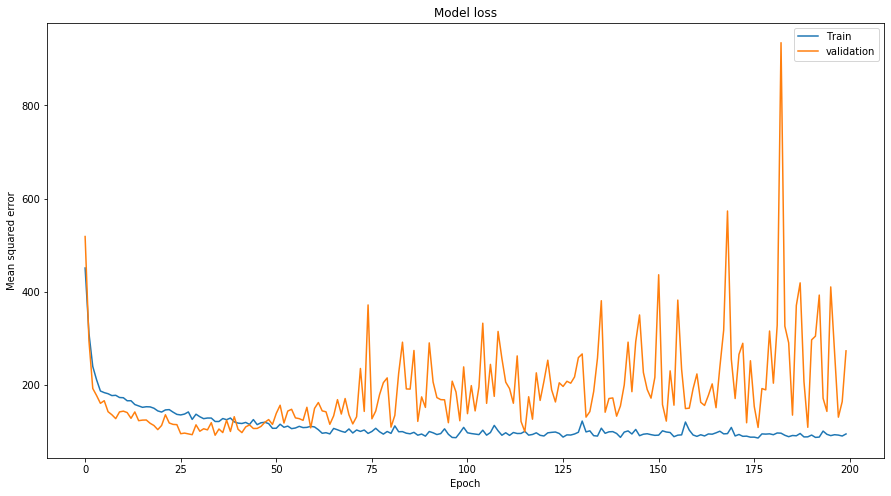

In [82]:
#by ploting the learning curves of the neural netwrok we can see that 100 epochs are enough train it 
plt.figure(figsize=(15,8))
# Use the history metrics
plt.plot(final_model.history.history['loss'])
plt.plot(final_model.history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(['Train', 'validation'])
plt.show()

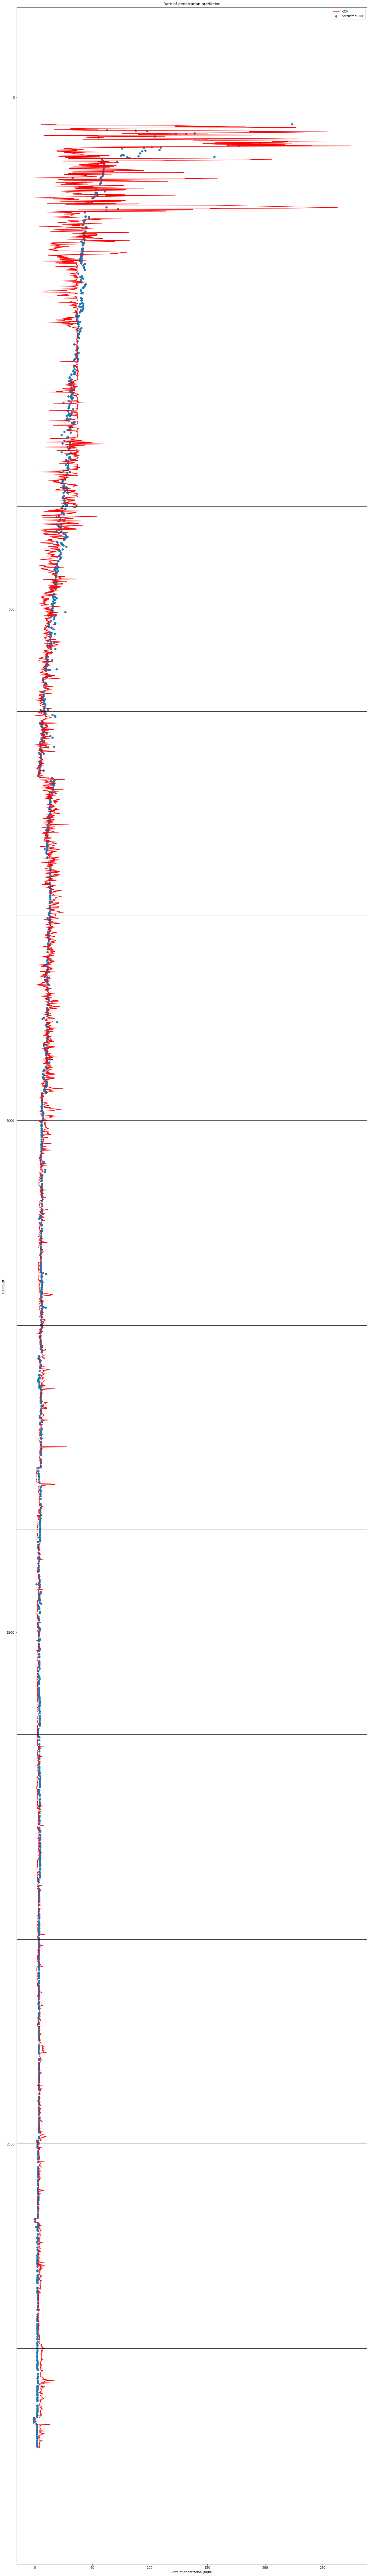

In [88]:
fig,ax=plt.subplots(figsize=(20,150))
ax.plot(y,X['Depth(m)'].values.reshape(-1,1),'r',label='ROP')
ax.scatter(predictions,X_test['Depth(m)'].values.reshape(-1,1),label='predicted ROP')
ay=plt.gca()
ay.set_ylim(ay.get_ylim()[::-1])
plt.ylabel('Depth (ft)')
plt.xlabel('Rate of penetration (m/hr)')
plt.title('Rate of penetration prediction');
plt.legend(loc="best")
depth=[depth for depth in range(200,2400,200) ]
for i in range(len(depth)):
    plt.axhline(depth[i],color='black' )
    